## Auto Spelling Correction

**In this Notebook we will go through the process of spelling correction using different NLP models**

In [1]:
#Importing the needed liberaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import time
import tqdm
import json
from difflib import SequenceMatcher
from itertools import chain
from wordcloud import WordCloud

import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda
from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Model
from keras.layers import Input,LSTM,Dense
from tensorflow.keras.callbacks import ModelCheckpoint

import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.corpus import words
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem import *
from nltk.stem.snowball import *
from nltk.tokenize import word_tokenize as WordTokenizer
from nltk.tokenize import PunktSentenceTokenizer
from nltk.tokenize import RegexpTokenizer
from nltk.metrics.distance import edit_distance

from collections import defaultdict
from collections import  Counter

np.random.seed(13)
nltk.download('stopwords')
lemmatizer = WordNetLemmatizer()
stopwords=set(stopwords.words('english'))
plt.style.use('ggplot')
get_ipython().run_line_magic('matplotlib', 'inline')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#loading the dataset
df = pd.read_csv("imdb_master.csv",encoding="latin-1")
df.head(10)

Unnamed: 0  type                                             review label  \
0           0  test  Once again Mr. Costner has dragged out a movie...   neg   
1           1  test  This is an example of why the majority of acti...   neg   
2           2  test  First of all I hate those moronic rappers, who...   neg   
3           3  test  Not even the Beatles could write songs everyon...   neg   
4           4  test  Brass pictures (movies is not a fitting word f...   neg   
5           5  test  A funny thing happened to me while watching "M...   neg   
6           6  test  This German horror film has to be one of the w...   neg   
7           7  test  Being a long-time fan of Japanese film, I expe...   neg   
8           8  test  "Tokyo Eyes" tells of a 17 year old Japanese g...   neg   
9           9  test  Wealthy horse ranchers in Buenos Aires have a ...   neg   

          file  
0      0_2.txt  
1  10000_4.txt  
2  10001_1.txt  
3  10002_3.txt  
4  10003_3.txt  
5  10004_2.txt  
6  10005_2.txt  
7  10006_2.txt  
8  10007_4.txt  
9  10008_4.txt

In [4]:
#spletting the dataset to train and test
df_train = df[df['type']=='train'].reset_index(drop=True)

## EDA

**In this part we explore the dataset to see what we are dealing with**

In [5]:
df.label.unique()

array(['neg', 'pos', 'unsup'], dtype=object)

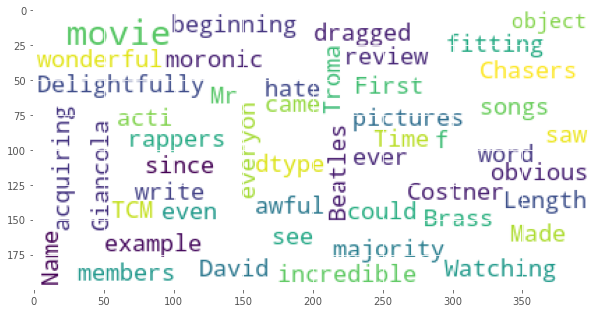

In [7]:
#Creating the word cloud to see what are the most common words in the dataset
cloud_data = str(df["review"])
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=300,
                          max_font_size=25, 
                          random_state=42
                         ).generate(cloud_data)
plt.figure(figsize=(10,15))
plt.imshow(wordcloud)

**We see the number of reviews on each class to understand the nature of the words in the dataset**

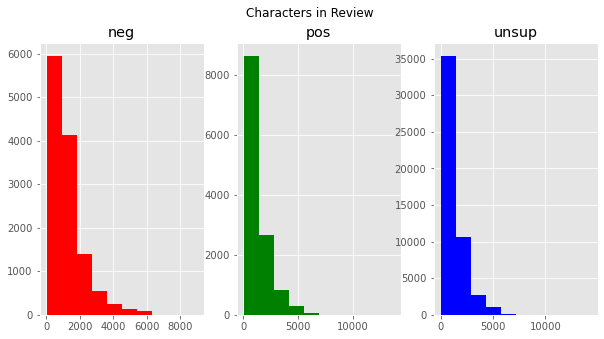

In [5]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(10,5))
df_train_len=df_train[df_train['label']=='neg']['review'].str.len()
ax1.hist(df_train_len,color='red')
ax1.set_title('neg')
df_train_len=df_train[df_train['label']=='pos']['review'].str.len()
ax2.hist(df_train_len,color='green')
ax2.set_title('pos')
df_train_len=df_train[df_train['label']=='unsup']['review'].str.len()
ax3.hist(df_train_len,color='blue')
ax3.set_title('unsup')
fig.suptitle('Characters in Review')
plt.show()

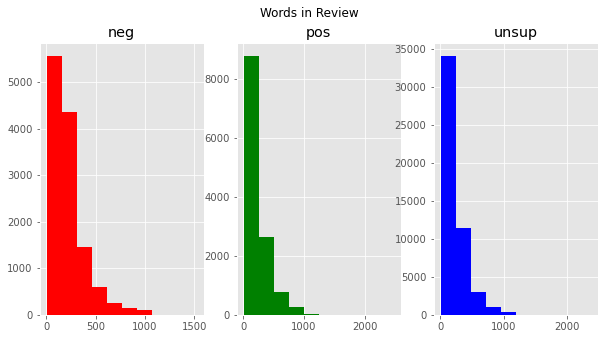

In [6]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(10,5))
df_train_len=df_train[df_train['label']=='neg']['review'].str.split().map(lambda x: len(x))
ax1.hist(df_train_len,color='red')
ax1.set_title('neg')
df_train_len=df_train[df_train['label']=='pos']['review'].str.split().map(lambda x: len(x))
ax2.hist(df_train_len,color='green')
ax2.set_title('pos')
df_train_len=df_train[df_train['label']=='unsup']['review'].str.split().map(lambda x: len(x))
ax3.hist(df_train_len,color='blue')
ax3.set_title('unsup')
fig.suptitle('Words in Review')
plt.show()


**Creating our corpus by taking the colum of reviews and adding it to our corpus to perform the NLP-specific EDA on**

In [7]:
corpus=[]
for x in df_train['review'].str.split():
    for i in x:
        corpus.append(i)


In [8]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))

dic=defaultdict(int)
for word in corpus:
    if word in stop_words:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 


**Reviewing the number of stopwords in the dataset**

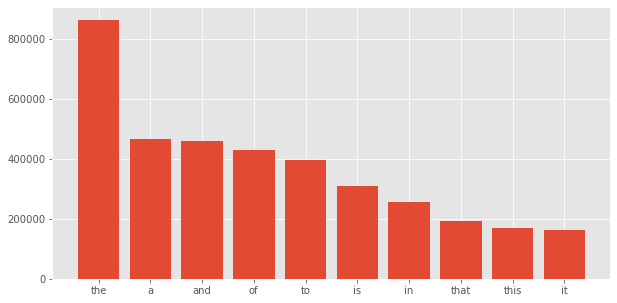

In [9]:
plt.figure(figsize=(10,5))
x,y=zip(*top)
plt.bar(x,y)
plt.show()

**Viewing the number of punctuation in the dataset**

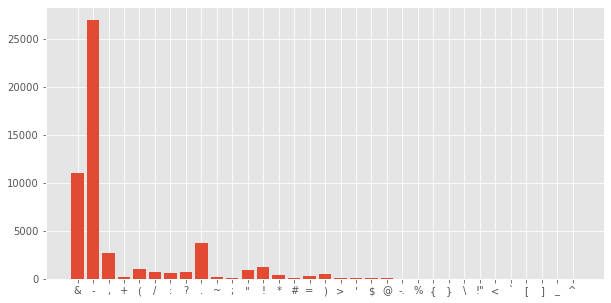

In [10]:
plt.figure(figsize=(10,5))
dic=defaultdict(int)
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)
plt.show()


**Viewing the most common words in the dataset**

<AxesSubplot:>

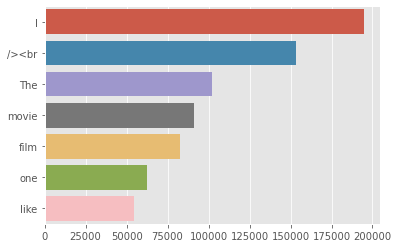

In [11]:
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop_words) :
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)


## Data Cleaning

**Here we start to clean our dataset from all the unnecessary data using some helper functions based on Regex**

<ul>
    <li><strong>URL_remove:</strong> this function removes any URLs from the dataset</li>
    <li><strong>html_remove:</strong> this function removes any HTML tags from the dataset</li>
    <li><strong>emoji_remove:</strong> as this is a movie review, it can be written from mobile phones and containing emojis; this function removes any emojis in the dataset</li>
    <li><strong>punct_remove:</strong> this function removes all the punctiuation as it is useless and makes the dataset so big and adding a lot of computational power</li>
    <li><strong>text_cleaning:</strong> this is a general function that contains some regex expressions to perform further cleaning on the data</li>
    <li><strong>str.lower:</strong> this function call from str library makes all the characters is lowercase</li>
</ul>

In [12]:
def URL_remove(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def html_remove(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def emoji_remove(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def punct_remove(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

def text_cleaning(text):
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text


In [13]:
#Appling the helper functions on the dataset
df['review']=df['review'].apply(lambda x : URL_remove(x))
df['review']=df['review'].apply(lambda x : html_remove(x))
df['review']=df['review'].apply(lambda x: emoji_remove(x))
df['review']=df['review'].apply(lambda x : punct_remove(x))
df['review']=df['review'].apply(lambda x: text_cleaning(x))
df['review']=df['review'].str.lower()
df=df.drop(['Unnamed: 0', 'file'], axis=1)


**Splitting the data into training and testing after cleaning**

In [14]:
df_train_clean = df[df['type']=='train'].reset_index(drop=True)
df_test_clean = df[df['type']=='test'].reset_index(drop=True)
df_train_clean.head()


type                                             review label
0  train  story of a man who has unnatural feelings for ...   neg
1  train  airport  starts as a brand new luxury  plane i...   neg
2  train  this film lacked something i couldnt put my fi...   neg
3  train  sorry everyone i know this is supposed to be a...   neg
4  train  when i was little my parents took me along to ...   neg

In [15]:
len(df_train_clean["review"])
df_train_clean["review"][0].split('.')


['story of a man who has unnatural feelings for a pig starts out with a opening scene that is a terrific example of absurd comedy a formal orchestra audience is turned into an insane violent mob by the crazy chantings of its singers unfortunately it stays absurd the whole time with no general narrative eventually making it just too off putting even those from the era should be turned off the cryptic dialogue would make shakespeare seem easy to a third grader on a technical level its better than you might think with some good cinematography by future great vilmos zsigmond future stars sally kirkland and frederic forrest can be seen briefly']

In [16]:
splitted_reviews=[]
splitted_reviews_sentences=[]
for i in range(len(df_train_clean["review"])-74000):
    splitted_reviews+=df_train_clean["review"][i].split(' ')
#     splitted_reviews_sentences.append(df_train_clean["review"][i].split('.'))
    splitted_reviews_sentences+=df_train_clean["review"][i].split('.')


print(splitted_reviews_sentences[0])
len(splitted_reviews_sentences)


story of a man who has unnatural feelings for a pig starts out with a opening scene that is a terrific example of absurd comedy a formal orchestra audience is turned into an insane violent mob by the crazy chantings of its singers unfortunately it stays absurd the whole time with no general narrative eventually making it just too off putting even those from the era should be turned off the cryptic dialogue would make shakespeare seem easy to a third grader on a technical level its better than you might think with some good cinematography by future great vilmos zsigmond future stars sally kirkland and frederic forrest can be seen briefly


1000

In [17]:
splitted_reviews

['story',
 'of',
 'a',
 'man',
 'who',
 'has',
 'unnatural',
 'feelings',
 'for',
 'a',
 'pig',
 'starts',
 'out',
 'with',
 'a',
 'opening',
 'scene',
 'that',
 'is',
 'a',
 'terrific',
 'example',
 'of',
 'absurd',
 'comedy',
 'a',
 'formal',
 'orchestra',
 'audience',
 'is',
 'turned',
 'into',
 'an',
 'insane',
 'violent',
 'mob',
 'by',
 'the',
 'crazy',
 'chantings',
 'of',
 'its',
 'singers',
 'unfortunately',
 'it',
 'stays',
 'absurd',
 'the',
 'whole',
 'time',
 'with',
 'no',
 'general',
 'narrative',
 'eventually',
 'making',
 'it',
 'just',
 'too',
 'off',
 'putting',
 'even',
 'those',
 'from',
 'the',
 'era',
 'should',
 'be',
 'turned',
 'off',
 'the',
 'cryptic',
 'dialogue',
 'would',
 'make',
 'shakespeare',
 'seem',
 'easy',
 'to',
 'a',
 'third',
 'grader',
 'on',
 'a',
 'technical',
 'level',
 'its',
 'better',
 'than',
 'you',
 'might',
 'think',
 'with',
 'some',
 'good',
 'cinematography',
 'by',
 'future',
 'great',
 'vilmos',
 'zsigmond',
 'future',
 'stars',

In [18]:
splitted_reviews_sentences

['story of a man who has unnatural feelings for a pig starts out with a opening scene that is a terrific example of absurd comedy a formal orchestra audience is turned into an insane violent mob by the crazy chantings of its singers unfortunately it stays absurd the whole time with no general narrative eventually making it just too off putting even those from the era should be turned off the cryptic dialogue would make shakespeare seem easy to a third grader on a technical level its better than you might think with some good cinematography by future great vilmos zsigmond future stars sally kirkland and frederic forrest can be seen briefly',
 'airport  starts as a brand new luxury  plane is loaded up with valuable paintings  such belonging to rich businessman philip stevens james stewart who is flying them  a bunch of vips to his estate in preparation of it being opened to the public as a museum also on board is stevens daughter julie kathleen quinlan  her son the luxury jetliner takes 

**As our mission is to perform spelling correction on misspelled words; we must have misspelled words which called noised words. In the block below we create the noised dataset by taking it review by review and noising it, then saving the noised dataset into a file for future use**

In [19]:
from neuspell.noising import WordReplacementNoiser

word_repl_noiser = WordReplacementNoiser(language="english")
word_repl_noiser.load_resources()
noise_texts = word_repl_noiser.noise(splitted_reviews_sentences)

with open('noised_data.txt', 'w') as filehandle:
    filehandle.writelines("%s ,\n" % review for review in noise_texts)


data folder is set to `C:\ProgramData\Anaconda3\lib\site-packages\neuspell\../data` script
Utilizing resources existing in folder C:\ProgramData\Anaconda3\lib\site-packages\neuspell\../data\noising_resources\en-word-replacement-noise
Utilizing resources existing in folder C:\ProgramData\Anaconda3\lib\site-packages\neuspell\../data\noising_resources\en-word-replacement-noise
total # of texts after retokenization: 1000
total # of tokens after retokenization: 213102
total lines in inp to noisyfy_word_tokens: 1000
total tokens in inp to noisyfy_word_tokens: 213102


  0%|          | 0/1000 [00:00<?, ?it/s]

unique tokens overlapped with replacement lookup: 7446
total tokens overlapped with replacement lookup: 184717
overlap percent wrt original_sentences: 86.6801
overlap percent wrt mistakes_vocab: 41.0633
23.0734% of overlapped tokens will get replaced to match the total % of misspellings to 20.0000%
Percentage of tokens that actually got replaced 41797/213102=19.6136%
No of tokens in mistakes_mappings queried: 4322


**Example of noised review**

In [20]:
noise_texts [0]

'story of a makin eweo has unnatural feelings for a pig starts out withl a opening as that is a terrific example of absurd comedy a format orchestra audience gis turned into an insane violent mob by the crazy chantings of its aingers unfortunately it stays absurd the whole time inh no general narratica evetually making it just too off putting even those from ght era should be turend off the cryptic dialogue would make shakespeare seem easy to a third grader on a technical level its better than you might think with some good cinematography ay future great vilmos zsigmond fyture ster saly kirkland and frederic forrest can ge seen briefly'

In [21]:
def _create_frequency_matrix(sentences):
    frequency_matrix = {}
    stopWords = set(stopwords.words("english"))
    #ps = PorterStemmer()
    ps=SnowballStemmer(language="english")

    for sent in sentences:
        freq_table = {}
        words = word_tokenize(sent)
        for word in words:
            word = word.lower()
            word = ps.stem(word)
            if word in stopWords:
                continue

            if word in freq_table:
                freq_table[word] += 1
            else:
                freq_table[word] = 1

        frequency_matrix[sent[:15]] = freq_table

    return frequency_matrix



def get_count(words):
    word_count_dict = {}
    word_count_dict = Counter(words)
    return word_count_dict

#word_count_dict = get_count(book_words) # dictionary with the count

# calculate probability of the occurrence
def occurr_prob(word_count_dict):
    probs = {}
    m = sum(word_count_dict.values())
    for key in word_count_dict:
        probs[key] = word_count_dict[key]/m #calculate prob for each word
    return probs


In [46]:
#from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))     
filtered_sentence = [w for w in splitted_reviews if not w in stop_words]



print(len(filtered_sentence)) 
print(filtered_sentence)
print(noised_sentence_filtered)


114307
['story', 'man', 'unnatural', 'feelings', 'pig', 'starts', 'opening', 'scene', 'terrific', 'example', 'absurd', 'comedy', 'formal', 'orchestra', 'audience', 'turned', 'insane', 'violent', 'mob', 'crazy', 'chantings', 'singers', 'unfortunately', 'stays', 'absurd', 'whole', 'time', 'general', 'narrative', 'eventually', 'making', 'putting', 'even', 'era', 'turned', 'cryptic', 'dialogue', 'would', 'make', 'shakespeare', 'seem', 'easy', 'third', 'grader', 'technical', 'level', 'better', 'might', 'think', 'good', 'cinematography', 'future', 'great', 'vilmos', 'zsigmond', 'future', 'stars', 'sally', 'kirkland', 'frederic', 'forrest', 'seen', 'briefly', 'airport', '', 'starts', 'brand', 'new', 'luxury', '', 'plane', 'loaded', 'valuable', 'paintings', '', 'belonging', 'rich', 'businessman', 'philip', 'stevens', 'james', 'stewart', 'flying', '', 'bunch', 'vips', 'estate', 'preparation', 'opened', 'public', 'museum', 'also', 'board', 'stevens', 'daughter', 'julie', 'kathleen', 'quinlan', '

NameError: name 'noised_sentence_filtered' is not defined

In [47]:
lmtzr = SnowballStemmer(language="english")
lemmatized_words = [lmtzr.stem(word) for word in filtered_sentence]
lemmatized_words


['stori',
 'man',
 'unnatur',
 'feel',
 'pig',
 'start',
 'open',
 'scene',
 'terrif',
 'exampl',
 'absurd',
 'comedi',
 'formal',
 'orchestra',
 'audienc',
 'turn',
 'insan',
 'violent',
 'mob',
 'crazi',
 'chant',
 'singer',
 'unfortun',
 'stay',
 'absurd',
 'whole',
 'time',
 'general',
 'narrat',
 'eventu',
 'make',
 'put',
 'even',
 'era',
 'turn',
 'cryptic',
 'dialogu',
 'would',
 'make',
 'shakespear',
 'seem',
 'easi',
 'third',
 'grader',
 'technic',
 'level',
 'better',
 'might',
 'think',
 'good',
 'cinematographi',
 'futur',
 'great',
 'vilmo',
 'zsigmond',
 'futur',
 'star',
 'salli',
 'kirkland',
 'freder',
 'forrest',
 'seen',
 'briefli',
 'airport',
 '',
 'start',
 'brand',
 'new',
 'luxuri',
 '',
 'plane',
 'load',
 'valuabl',
 'paint',
 '',
 'belong',
 'rich',
 'businessman',
 'philip',
 'steven',
 'jame',
 'stewart',
 'fli',
 '',
 'bunch',
 'vip',
 'estat',
 'prepar',
 'open',
 'public',
 'museum',
 'also',
 'board',
 'steven',
 'daughter',
 'juli',
 'kathleen',
 'q

# show dependences

In [49]:
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_lg')

In [50]:
for i in splitted_reviews_sentences:
    
    doc = nlp(i)
    
    for sent in doc.sents:
        docx = nlp(sent.text)
        if docx.ents:
            displacy.render(docx, style='ent', jupyter=True)
        else:
            
            print(docx.text)


 theres not as much urgency as i thought there should have been even when the navy become involved things dont pick up that much with a few shots of huge ships  helicopters flying about


so far  
i liked the ideas behind it even if they were a bit silly the production  bland direction doesnt help though  a film about a sunken plane just shouldnt be this boring or lethargic followed by the concorde  airport  


sorry everyone i know this is supposed to be an art film


well lying
when i was little my parents took me along to the theater to see interiors it was one of many movies i watched with my parents but this was the only one we walked out of since then i had never seen interiors until just recently


whatever and it just goes on and on to the point where you just want to slap all of them its never about resolution its only about interminable introspective babble it is nothing more than a psychological drama taken to an extreme beyond the audiences ability to connect woody allen chose to make characters so immersed in themselves we feel left out and for that reason i found this movie painfully self indulgent and spiritually draining i see what he was going for but his insistence on promoting his message through prozac prose and distorted film techniques jettisons it past the point of relevance i highly recommend this one if youre feeling a little too happy and need something to remind you of death otherwise lets just pretend this film
never happened


the new yorker


this film is mediocre at best angie harmon is as funny as a bag of hammers her bitchy demeanor from law and order carries over in a failed attempt at comedy charlie sheen is the only one to come out unscathed in this horrible anticomedy the only positive thing to come out of this mess is charlie and denises marriage hopefully that effort produces better results
the film is bad there is no other way to say it the story is weak and outdated especially for this country i dont think most people know what a walker is or will really care i felt as if i was watching a movie from the  the subject was just not believable for the year  even being set in dc


and kristin boringdont see it it is painful unless you are a true harrelson fan


and i mean everything in between is basically the directors desperate effort to fill in the minutes i like disturbing movies i like dark movies
and i dont get troubled by gritty scenes  


 youll probably have more interesting dreams
plot is not worth discussion even if it hints at corruption murder power and the rest of thriller related topics characters are interesting though sometimes not realistic but interesting neverthelessdevelopment is slow like tea drinking ceremony visuals not stunning but good enough to ease the eye strain good movie to watch after dinner before going to bed
 nothing shocking too much nothing overexciting movie sitcom stylei liked woody  excellent performance had to fight the plot inadequacy and did the job pretty good the rest are bearable though very predictable the whole is watchable and better than most tv
shows
this film is about a male escort getting involved in a murder investigation that happened in the circle of powerful mens wivesi thought the walker would be thrilling and engaging


even worse pacing


 i just sat in utter amazement during this movie thinking how on earth can anyone find this movie entertaining the producers of this movie were very clever they made a boring movie but hid it well with the names of good actors and actresses on their cast people will go to the blockbuster and probably see this movie and think woody harrison kristin scott thomas and willem dafoe this must be good and rent this movieboy are they in for a horrible timeif
you like getting ripped off go and rent this movie some people actually did enjoyed this movie
but i like to watch a movie with meaning


thomas this one is definitely one to miss


ghost of dragstrip hollow is a typical  teens in turmoil movie it is not a horror or science fiction movie plot concerns a group of teens who are about to get kicked out of their hot rod club because they cannot meet the rent once kicked out they decide to try an old haunted house the only saving grace for the film is that the ghost paul blaisdell in the she creature suit turns out to be an out of work movie monster played by blaisdell
ghost of dragstrip hollow was one of the many  movies about hotrodding teens encountering the supernatural in this case the teens cant pay the rent for their hangout and get evicted with nowhere else to go they decide on an apparently haunted house as you may have guessed once they arrive some weird things start happening and theres a twist at the endtheres nothing in this movie that you havent seen in other movies but its nice entertainment nonetheless my favorite character was the foulmouthed parrot well let me rephrase that he didnt talk like a charac

the characters are unlikeable and the script is awful its a waste of the talents of deneuve and auteuil
kareena kapoor in a bikini hmmmmmmmmakshay kumaranil kapoormaybe saifkareena kapoor in a bikinigood bannerkareena kapoor in a bikininot one good reason not to see this movieor


is
i rented this on dvd and i kind of feel bad since dawson and lugacy are so earnest about it in the dvd comments its not a bad movie exactly but its one of those films that desperately wants to be a deep comment on human nature while not realizing that its story is practically a genre plus it is a little simplistic about the issue in a lot of ways and the characters behavior often strains belief id say its a film that you would get something out of if you dont have a lot of filmtvliteraturelife behind you to be honest ive seen almost exactly the same story in horror comics even otherwise its point has been made before and more artfully and that gets to the big problem which is that it really doesnt have much of cinematic interest to it besides the point it ends up being a fairly bland movie overall that invests everything in the idea that the basic story will be shocking and compelling and it doesnt really pay off


sanjay mishra manoj phawa and yashpal sharma are wastedtashan is a boring film the films failure at the box office should you keep away
the worst movie i have seen since tera jadoo chal gaya there is no story no humor no nothing the action sequences seem more like a series of haphazard akshay kumar thumbsup advertisements stitched together heavily influenced from the matrix and kungfu hustle but very poorly executedi did not go a lot of expectations but watching this movie is an exasperating experience which makes you wonder what were these guys thinkingthe only thing you might remember after watching it is an anorexic kareena in a bikinithe reason why i did not give a rating of  is that every time i think i have seen the worst bollywood proves me wrong


so i may exaggerate on the percentage
but you get my drift besides stuff from hollywood bollywood too have their own share of highly anticipated blockbusters and from some of the trailers shown im hyped to watch them too tashan was billed as one of the most highly anticipated for  
but i was quite surprised at the lower than low turnout at the cinemas when i watched jodha akbar it was a full house


i think vaibhavi merchant just sleep walked through this film vishalshekhar have put up a good score
but it does not belong to this film why is there a sufi song dil haara in tashan why is the cool hinglish song dil dance maare not on anil kapoor when he is the one who is english crazy akshay kumar is the saving grace of the film but he is in his stereotyped self
you wont mind missing this film


well you can watch this to have some laughs at the terrible fight scenesthats all


well but this cannot be said for anil kapoor  


i dont want to go too far into detail because i cant really justify wasting much time on reviewing this film but i had to give an alternate opinion to hopefully help people avoid the movie the animation is crud and the story alternates between boringpointless to extremely irritating the humor was completely lost on the audience and yes  ghost in the shell fans this is not an action scifi or anything like that  its an attempt at slapstick comedy and the humor just did not work after being translated it was a total chore to watch this movie and horrible way for me to kick off the film fest especially considering how excited i was and how open i was for anything  
i wasnt expecting a ghost in the shell sequel but i was expecting something entertaining and it simply didnt achieve this yaaawwnnn rent kinos journey instead


but she did not looked good leaner


and i have never seen such bad action akshay kumar was between a circle of  policemen all shooting at him and he shooting back at them none of the policemens bullet touched him but he killed all the policemen crap crapi think the fight director who thought of this scene should take retirementi strongly recommend not to see this movie


in the future im sure these action movies will get much sharper also to be noted comedy and action films do not mix unless done properly good luck next time


then anil kapoor


but then his act gets repetitive and he overacts then came akshay who provided some nice scenes but then the film became more boring and with all the outdated stuff childhood romance overdose of childish rajnikant style action scenes and all boring scenes the ending is another jokevijay krishna acharya would have got  films more to direct if this film had worked thats the strategy of yashraj only money nothing else so vijay is another addition to their list of crap filmmakers music vishal shekhar is ordinaryperformances akshay kumar comes in the film as a whiff of fresh air he actually provides some engaging moments saif ali khan is irritating kareena is equally bad anil kapoor hams outrageously and spoils the show even more rest are okay
absolutely awful movie utter waste of timebackground music is so loud that you cannot understand speech well if you really listen closely whatever they speak is actually unintelligiblecamera work is bad editing is not present background score gives a 

i would say watch it to listen to that background song which goes something like bachchan bachchan pandeyoverall very disappointed even with the way bhaiyyaji has made attempt to speak bad englishgo away man i need to puke
i had never thought the standard of yashraj films would ever degrade to such an extent the film has a nonsense storyline which catches no interestsaif has over acted kareena has improved her figure but is not a good actress anyway akshay is good anil is also good may i say the role wasnt goodgreat deal of cheapness is filled in wondered if that was supposed to be the comedy part of the movie just because last few movies were flops does that mean yashraj films should make this kind of rubbish it has a history of so many good films overall i was totally disappointed with the movie


but i really liked iti am forced to give it a  
but id really give this movie a  an unachieved film


and you wont be disappointed vishal shekhar come up with some eminently hummable tunes how i wish the director had spent the money in creating some more eye candyas i sign off i want to really badly know how does akshays bullet wound vanish in a microsecondwhat were you editors doing tashan maybe


but of course if tashan is salvaged to some extent its thanks to akshay kumars irresistible presence and his spontaneous approach to the character you cringe when hes cupping his crotch repeatedly and you scowl when he delivers those doublemeaning dialogues but not for a moment can you take your eyes off the screen when hes up
theredespite some good music from vishalshekhar the songs seem like theyre only prolonging your misery well thats because tashan is a test of your patience in case
you didnt know tashan means style im sorry to say this film has none
such a long awaited movie


alright nevertheless the way the intrinsic beauty of these places was shot made me want to find out exactly where those places were and when i could go there action sequences were shot very shabbily no one could make out head  tail of the stunts theyve used akkiakshay kumar very well but couldve been done much much betteranimation is the worst ive seen in recent  movies had better animation scenes i guessinitial scene where the car is falling off flying should be better word the road into lakeand the movies name has been mentioned nearly every  to  mins just to make sure audiences dont forget the movie name
i guess


 
i swear the audience leaving the hall seemed to be in a mood to kill someone  movie piraters more power to them if any movies deserves to not have the audience spending money to watch  this is it  most types of plankton  green algae  because almost all other living things would require an iq factor somewhat greater than what the movie offers afterthought the director of the movie obviously is a species of his own  and i hope to god that he is the only one of his kindone is enoughthings that could have made this a better movie  a story  a choreographer  a screenplay writer  a stunt coordinator  a story did i already say that  a director  preferably one who is not mentally challenged although even one who was challenged could have done a better job  anil kapoorbubonic plague  avoid at all costs  a statutory warning  watching yash raj movies is injurious to your mental health things i liked about the movie  kareena kapoor  for obvious reasons  the english subtitles  mera dil kho gaya be

i was disappointed
i wasnt terribly impressed with dantes  season offering in homecoming it wasnt much of a horror story but rather a smart political statement with the undead screwfly situation is the story of a virus unleashed on the world that causes mens sexual drive to replaced with murderous tendencies toward women the episode starts out all right with a short film explaining the way the screw fly was killed of by scientists then there is short scene where a man is arrested when females bodies are discovered in his home i assume this is supposed to show the beginning of the outbreak but is unclear because this is never revisited the episode go ons for a while introducing characters blah blah blahit seems cool and mysterious but
the episode stars to get worse and worse as it lurches forward until its sad and unsatisfying end the worst episode well except for chocolate
ive now written reviews for several of the moh episodes and this is among the worst an interesting premise at the 

far too seriously  
i dont really understand why its part of the masters of horror series the horror that the filmmakers are going for in the screwfly solution is in the actual story itself  themes  ideas it brings up rather than on screen visual horror particularly the tenuous ecological message it sees intent on ramming down our throats whenever its gets the chance during its short  odd minute running time which i felt itself was a problem as the thing just finishes out of what could easily be interpreted as necessity rather than any meaningful attempt to wrap things up i wasnt happy with the inconsistencies with the story either if men only kill when sexually aroused why does the flight attendant casually break that womans neck on the plane was he sexually aroused i think not why does every bloke then think hes killing in the name of god i just cant see every single bloke on earth suddenly knowing the bible  starting to believe in god i just found the notion ridiculous  the show als

i love the frequently misnomered masters of horror series horror fans live in a constant lack of nourishment projects like this and the similar greenlight project with gave us feast  like it or lump it are breeding grounds for wonderful thought bubbles in the minds of directors with a horror bent to develop and bring to maturation food for we who love to dine on horrorthis one began with a kernel of reallykoolidea and ran  right off the edge of where in the world am i going with thisi dont know how to spoil the spoiled but spoiler ahead all of a sudden  
no there was that light drifting across the night sky earlier  we have long haired luminescent aliens huh  huh brain drilling males and  
yeah
i get it but  
well  the worst curse of storytelling  a rousing and promising set up without a rewarding denouementcue to storytellers  your build up has to have a payoff that exceeds build up not the other way around storytelling math  of spoilers
 big oops


boring


i grew up on the superman ii theatrical version  and as a kid i loved it more than part


unfortunately the worst change comes last gone was also the weird amnesia kiss from  replaced with the exact same ending as i this is not only a lazy unoriginal copout it doesnt make sense on why clark would go back to that diner if those events never actually happened and will he continue to turn back time for every confrontation


i was fascinated as to how truly bad this movie was was the viewer supposed to learn something or reflect on anything here what was up with the pumpkins was i supposed to be impressed with the motel shots does it matter that there are some garbage bags on a rooftop across the street of a hotel why does the narrator unsuccessfully mock the people he interviews it is so obvious that he edited out the really informative parts of his interviews to achieve mockery the best part of the movie was the interview with the film professor who tells us how bad this movie will be even before it is finishedi am truly amazed i believe that the creator is struggling to become an intellectual or is trying to impress the intellectual community


the author sets out on a journey of discovery of his roots in the southern tobacco industry because he believes that the completely and deservedly forgotten movie bright leaf is about an ancestor of his its not
and he in fact discovers nothing of even mild interest in this absolutely silly and selfindulgent glorified home movie suitable for screening at the directors drunken family reunions but certainly not for commercial  or even noncommercial release a good reminder of why most independent films are not picked up by major studios  because they are boring irrelevant and of no interest to anyone but the director and hisher immediate circles avoid at all costs
the curse of frankenstein sticks faithfully to mary shelleys story for one word of the title which wouldnt be so bad if the changes were any good at all the tragedy of the creature destroying frankensteins family has been completely excised and replaced with nothing the heart and moral centre of the story is gone it doesnt help t

its crap


alongoh godwhere do i even begin the plot sucked the voice acting sucked the animation sucked the ending really sucked if you liked this movie you suck too and to  who said this was the greatest movie ever you are a tool plain and simple this isnt a movie for anyone but crackaddled tenyear olds with game boys who think pikachu is god im still cry to this day thinking about that horrible turd of a movieand then there was pikachus adventuredont even get me started on that horrible mess of a film it is in all truth one of the most boring experiences of my entire life dont go watch this at any costsbottom line go out find every copy of this movie that you can and burn it burn them all and then proceed to rent a good movie like aliensor bowling for columbineor even back to the future


©mon episodes to understand whats going on and it is not a film it is just an animation it should be on videops ill give it a  because i just got  bucks i could not give it a half because theres no halves


well maybe the next one will be bettercant
ge t much worse


its much better
i recently watched this again and theres another version which is shorter  
i get the feeling they are the same movie


lives


oh and lots of gun fire i mean a whole lot


mistaken identity  impersonation is a plot development since rogers essays a dual role rogers is charming as usual but there is nothing really elevating this his performance above the ordinary  any potential to deliver a memorable jekyllhyde performance is done in by poor material the better pair to watch are ms storm and ms paye as the st louis journal reporters
 they are the films highlight the songs are fine though badly synched  jesse james at bay  joseph kane  roy


i saw this film at its premier at sundance  american beauty is a movie that had something to say i had hopes for towelhead


it embarrasses me to read them but it does not surprise me indeed ive encountered many people who seem to regard any book or movie dealing with racial cultural gender or sexual issues as deeply moving thought provoking full of profound insight if you are such a person by all means rent towelhead and be moved by it on the other hand if you set your standards higher you can safely pass on this one


hunkyaustralianboycantfitintooutsidersdominatedschoolergogoesfor
toughguywithstupidbikerhelmetlook


sid caesar and dody goodman all faculty members from the original grease return in their roles the music score isnt remotely as good as the songs that come from the originalits not that grease  is bad
its just not all that great
well at least my theater group did lol
so of course i remember watching grease since i was a little girl while it was never my favorite musical or story it does still hold a little special place in my heart since its still a lot of fun to watch i heard horrible things about grease  and thats why i decided to never watch it but my boyfriend said that it really wasnt all that bad and my friend agreed so i decided to give it a shot


but apparently she didnt the songs were not really that catchy im glad that michelle was able to bounce back so fast but thats probably because she was the only one with talent in this silly little sequel i wouldnt really recommend this film other than if you are curious but i warned you this is just a pathetic attempt at more money from the famous
boygirl love affairsequel with songs only this time shes the punkette
and hes the straight arrow moviebuffs out there actually like this movie it has fans i must say the mind reels grease  is a truly lame enterprise that doesnt even have the courage moxy or sheer gall to take the memory of its predecessor down in flames like jaws  or exorcist ii


and
although she doesnt embarrass herself its a role worth forgetting a misfire on the lowest of levels no stars from
when i was  grease  was like crack it was a classless shameful euphoric and powerfully addictive experience my sister and i would watch it rewind it and watch it over again and again and again until we passed out or became too confused and hostile to stand one another


i guess she harbors no likable characteristics thus audiences are given no justification whatsoever for the depth of michaels attraction to heri could go on and on


i had to do a search on the actresses to find the board of this film because the title is now an unexpected love its not really worth looking for but i was unfamiliar with both leads and wondered why they were headlining a lesbian flick on lifetime everythings pretty restrained and you dont really get an idea of who these characters are so as a viewer i wasnt able to become emotionally invested in the storyline i guess im not the target audience for this


but then she either wasnt allowed by studio execs to give the story some truetolife gusto or didnt have the cojones this movie could go in the enyclopedia as the standardissue bad lifetime tv movie


yep theyre lesbians nothing rings true in this lifetime for women with nothing better to do movie clunky dialogue like i dont want to spend the rest of my life feeling like i had a chance to be happy and didnt take it doesnt help theres a wealthy distant mother who disapproves of her daughters new relationship a sassy black maid  unbelievable that in the year  a film gets made in which theres a sassy black maid hattie mcdaniel must be turning in her grave the woman has a husband who freaks out and wants custody of the snotty teenage kids sheesh no cliche is left unturned


this movie was okay
but it certainly defeats the claim that homosexuals are born that way especially when a woman can exit out of an unhappy marriage and just fall into the arms of another woman it almost seems as if kates gender preferences turned on and off like a switch making this film seem a little simplisticalso as is common with films that are trying to push an agenda it was unfortunate that those characters in the film who had questions or disapproval over the gay lifestyle were labeled as bigots and there was no happy medium it was either kates friends and relatives totally embraced her or they totally shunned her this is not typical of interactions between gay and nongay relatives and friends it is usually a mixture of emotions and values that come into play it is possible to love people and treat them with respect while not necessarily condoning the choices they make sadly the movie showed none of these types of interactions for a movie trying to portray tolerance and accept

i am an actorproducer director and what i am about to say are facts this project was the worst film in movie making history from producer to director and the edit of this so called film is a joke and i mean a big joke why would blockbuster released such crap i take my work very serious and this film is an insult to my profession was the director trying to make a bad movie i dont think so i seen bad zombie movies but this takes the cake the coffie and everything on the damn table this movie sucks i really hate to talk bad about other filmmakers because i am one myself but please consider in taking up a different profession i respect the fact that you completed a movie but i have to ask you  were you smoking crack  


er i mean as they did before becoming zombified this gives our auteur ample opportunities to shower us with more of his golden dialog yes a golden shower it isi wont spoil anything by revealing the shock ending all i can say is its perfectly in tune with the rest of this masterpiece the spirit of ed wood lives on or should i say his geist


you can actually sing


anywhere even a  year oldand lastly why was this movie made at all why why why no answer thats what i thoughton the demand channel they actually issued this comment after the synopsis of the movie we apologize for this movie in advance lol at least they had the decency to do this
much


it is never explained
seriously crappy moviefirst off the movie starts with a cop and his partner parked outside of a warehousefurniture store the bad cop takes a girl which they had pulled over into the warehouses attic while the newbie cop sits outside and ponders what could be happening up there the bad cop eventually returns with a heavy duffel bag and the newbie cop doesnt think there are any problems but he still wonders what was in the bag so he asks gets a bullshit response and then he thinks everything is ok for nowthe bad cop repeats this process and even once with a tit scene made it slightly better but eventually people start to catch on which took awhile considering how fing obvious it was one girl gets a voodoo curse placed on her just in case she dies like ya do now the bad cop eventually kills this magically protected bitch and then he gets rid of the duffelbagged bodysince she had the oogeyboogey magic put on her she comes back with lots of eyeshadow on which is suppos

not worth the video rental or the time or the occasional effortsmakeup that a child can do acting was over donepoor directing editing was very choppymany things made no sense or just seemed gratuitous sound was badly dubbed music was highly inappropriate casting was extremely offmust have been on crack zombies that talk let alonedrive dance workjust pisses me off and the bad guyholy crap as horribly casted as he washe was the best looking zombie of all which doesnt say muchthe cover art was good but very deceivingas was the main menu of the dvdgreat artwork and musicdont
bother


if your after cheap laughs and you see it in pound land go by it
usually i support independent art and i try to be very comprehensive and toleranti tend to support everybody because their efforts are worthbut this movie just moves away from all comprehension and tolerance limitsimagine the following  think about the really worst horror movie you have ever seen in your life so  think about some great attractive art for that movies dvd boxand a promising  voilã  you got zombie nationsee it only if you really dont have anything else better to do anything is better
notice i have given this  star if the option been given i would have given this zero as i put this dvd into my tv and sat down on my couch i was expecting some of the worst film making at its finest i looked this movie up on imdb and saw that it was the worst rated movie
so i guess i came into it critical of every mistake
but it didnt prepare me for the crap that was about to spew from my television screenthe box makes this movi

and so could someone who had never seen a movie before its pitiful and without doubt the worst movie of all timehonestly the very worst movie of all time youll note by the way that the only positive reviews give this a  and urge you to buy the dvd i cant imagine anyone neutral genuinely thinking this is a good film its  and thats generous
this movie had me going the title was perhaps the greatest idea that i heard i thought it was an independent movie about a zombie outbreak and their quest to take over the us and a group of lone survivors band together and plan to take out the zombies dead wrong its about a psycho cop with a weakness for killing his female arrests gets whats coming to him when a pack of zombie women rise from their graves in order to get proper revenge as you can see there is nothing about the nation nor a county involved where to begin with the severity this cinematic disaster caused our nationfirst off the zombie women look like victoria secret models with dark eyel

zombie nation  rhey i was bored i looked in my comcastic little box to find a movie to watch zombie nation


but you wouldnt know it buy the sharp clean clothes theyre all wearing the women then act very poorly and take their revenge
oh yaythis film was crap in every category crap acting crap writing crappier sets and crappier makeup effects the women dont look zombielike unless you count really dark makeup around the eyes to be the de facto definition of what makes a zombie they can all talk behave think and act perfectly human the gore is weak compared to even many  films and the nudity is beyond brief you see glimpse of breasts in the opening sequence then the exact same breasts later go figure guess only one actress was willing to go topless for this trite the police station is so badly constructed that you can see where they stopped painting the walls of the warehouse theyre obviously filming in you can see the pipes and the bad lighting and the overly sparse setup and even unless you are blind you can see the director failing steer clear its a waste of
yeah


oh well what can i expect from a movie where they throw in a random fight scene for no good reason in a warehouse where they apparently ship boxes of air around the world so for all of those who worship mystery science theater  or if you just like reaming on bad c movies c for craptastic then this is the movie for you    or
not


do not watch


er i mean as they did before becoming zombified this gives our auteur ample opportunities to shower us with more of his golden dialog yes a golden shower it isi wont spoil anything by revealing the shock ending all i can say is its perfectly in tune with the rest of this masterpiece the spirit of ed wood lives on or should i say his geist
btk killer green river killer zodiac killer the man keeps putting out absolute garbage and the ironic thing is he loves his crapive never seen a ulli lommel film


nothing really happened


horrible acting bad story line cheesy makeup and this is just the tip of the iceberg i have never seen a worse movie in my life


â i think its a greater crime to make a boring film than a bad one and ulli lommel deserves credit for producing a film that actually stuns you with its ineptitude he really is the ed wood jr of the digital age
and i for one cant wait to see if he makes another film as consistently ridiculous as this one


classichowever
i cant possibly imagine anyone thinking this is anything but one of the worst movies ever made the real horror in this film is how bad it is im embarrassed i rented it and vow never to see another lommel film again
this is one of the worst films ever i like cheesy movies
but this is simply awful where are the images in the film that are on the box i think more money was spent on the dvd box illustrations than on the entire film why would a company release a dvd that the cover is so misleading i feel like such an idiot for renting this movie based strictly on the box as much as i explore imdb i should have done a little research and made a list prior to visiting my local video rental store i have no one to blame except myself i want my money and time back do not watch this movie even if curiosity is motivating you stick cocktail umbrellas in your eyes instead it will be much more enjoyable
you have been warned
i have made it my personal mission to go after those responsib

and i thought it looked like just the movie for my mood i brought it home and put it onthis movie was not the b horror movie that i had in mind this was much worse i wanted a bad movie but what i got i didnt know that crap like this existed amongst man this movie seemed like a  year old wrote and directed it and that is being nice about iti am an aspiring director and this movie made me so mad that someone out there is actually paying this guy to direct movies he needs to work at a garbage dump shoveling crap where he belongsif you are thinking about renting this or buying it i will tell you the same thing that i would tell someone getting ready to commit suicide dont do it its not worth it
i really have nothing nice to say about this movie dont do it


new yorks social set


is clearly slumming
this hitchcock movie bears little similarity to his later suspense films and seems much more like a very old fashioned morality tale a young couple receives an inheritance that they believe will make them happy they spend the money traveling about the world and living a very hedonistic existence however after a while the excitement begins to wane and the couple become dissipated and pointless in their existence however out of no where when they are on a luxury cruise the ship sinks and they lose everythingand end up much happier in the end because they now appreciate life what an odd silly and preachy film personally id like to inherit all that money and find out if it makes me miserablethe production values are relatively poor compared to later productionsa rough film with poor sound quality and rather amateurish
acting


but they remain as boring as they were before arguably bored director alfred hitchcock tries to liven up the welltitled as quoted in the film from shakespeares the tempest rich and strange by ordering up some camera trickery an opening homage to king vidors the crowd is the highlight the low point may be the couple dining on chinese prepared cat rich and strange  alfred hitchcock  henry kendall joan barry percy marmont elsie randolph


no in fact the last thing on your mind is watching the next episode this show is so boring that i cant see how it ever got made let alone released on dvd obviously the effects are not up to par with contemporary batman films but even the script is awful an incoherent babbling mess about some evil professor and a ray gun or something like that i am not quite sure because it is too awful to follow watch the  version or the  versions or even batman begins just anything over this version
this would have been what you gotwords alone cannot describe how bad this is if youre having trouble sleeping pop this in


this is not the  version


what about us scummy working class kids who never never had a loft and a back garden which was nothing more than a  meter square of balcony on the  floor of a council block public service broadcasting  
yeah right and on top of that it was awfully depressing to see those stupid middle class uptheirownbackside kids mess about with bits of old plastic having fun do me a favour and why dont you go and slit your wrists or do a coke overdose on mama and papas money you make me sick


and i suspect the workers that had to make the dvds had to wear protective gear and receive regular counseling


hell hes done it before and stallone will have managed to do it before him rocky balboa this isnt a flight of fury it isnt even a flight of fun its a flight that fails to even take off the ground
unless you are mentally ill or the most die hard segal fan you will tire of this horrendous excuse for a film in under  minutesthe plot  even for a seagal film the plot is just stupid
i mean its not just bad its barely coherentthe acting  unbelievably wooden literally seen better acting in pornos ironically this film tries to cash in on this audience


but it seemed like a lame attempt to get more guys to see it the camera would randomly zoom in on actors and skip to random scenes
oh yeah
since its a steven segal movie its predictable as hell all in all i rank it right up there with snakes on a plane


what a hoot


youve gotta hand it to steven seagal whatever his other faults may be he does have good taste in women if you pick a seagal movie chances are there will be one or more very beautiful women in it and usually they do not function as mere eye candy they get involved in the action and fight shoot guns kill with knives etc flight of fury offers the duo of ciera payton who has a very sexy face with luscious lips to match angelina jolies and katie jones and finds time to get them involved in both a catfight and a little lesbian fondling and if it seems like im spending a little too much time talking about them its because the rest of the movie although passable is so unexciting that its hard to find much else to talk about ironically the weakest aspect is probably seagal himself who looks as if he cant even be bothered to try to pretend to care this being a militarytype actioner there is very little fighting in it and he doesnt fit into his role a stealth fighter pilot the best in the world o

but i really prefer an actor not this android called timberlake and his girlfriend was shallow hollow and annoying as hell i was happy when they both were popped in the streetthe story was ok


but i think timberlake ruined it all it would have been much enjoyable without himby the way the music was ok but suddenly every time the music appeared the movie turned into a mtv video clip with flashes low motion and things like that something misplaced for this cops movie i thought maybe they wanted to make a mtv video clip for timberlake


is the fact that seagal never fights in hand to hand combat with the films chief villains tis a shame he doesnt even snap a wrist or crack a neck in any visible waysure we see a slight resemblance of some tool getting tossed around but its not as clear a picture as i enjoy because the filmmakers have such fast edits and dizzying closeups


 theres no real excitement in it the villains are boring as are the heroes  
its right down there with the worst seagal has madeflight of fury seems to be made up largely of stock footage which isnt even matched up that well the background can change peoples clothes change the area changes the sky  the quality of film changes very abruptly as its all too obvious we are watching clips from other better films spliced in hell seagal never even goes anywhere near a plane in this the action scenes consist of shootouts so badly edited its hard to tell who is who  of course seagal breaking peoples arms the whole production feels very cheap  shoddythe imdb reckons this had a budget of about  which i think is total rubbish


i
ve


existence


timberlakes performance almost made attack the screen it wasnt all bad i just think the reporters role was wrong for himll cool
j played the typical rapper role toughestbaddest guy around i dont think the cracked a smile in the whole movie not even when proposed to his girlfriendmorgan freeman pretty much carried the whole movie he was has some funny scenes which are the high point of the moviekevin spacey wasnt good or bad he was just thereoverall its a dull movie bad plot a lot of bad acting or wrong roles for actors


frank mc hugh and the everpresent john litel


but in fairness color
would not have helped


okay other than that its a fun movie flynn and the gang are always great no matter what history theyre destroying if flynn would just play his rotten self id double my rating
being a fan of cheesy horror movies i saw this in my video shop and thought i would give it a try now that ive seen it i wish it upon no living soul on the planet i get my movie rentals for free and i feel that i didnt get my moneys worth ive seen some bad cheesy horror movies in my time hell im a fan of them
but this was just an insult
slashers  outta  starsnot really a very good movie


i would imagine


they call a


shes no super model but more of a cute girl next doorok
so she cried and screamed a lot its very dramatic and seems overdone but doesnt it fit her character she goes on that show with the intention of sacrificing her life to prove a point she thinks people who enjoy such a show are sick i think she made her argument very well of course being a young naive girl she is terrified of what she is about to face i think her acting accurately portrays a young girl showing moral courage despite her overwhelming fear furthermore i think she maintained a certain dignity throughout the film despite the desperate situation she was inas for the movie in general other than megan
it was pretty much what i expected it had excellent gore scenes by microbudget standards the plot maybe took a quick thought hardly any contemplation its basically just a dark humorist senseless slasher film which the name implies i love the sadism of the doctor he kept ripping megans shirt off not just for the cause of sleaz

should be mentally evaluated


so anyway i would recommend you watch it and make up your own mind


but she predictably treats him with contempt until they finally hook up this may seem like a rather thin plot but this noisy movie is so chockfull of singing and music that there is barely any dialogue at all this movie is relentless forget about torturing hippies and war prisoners with slayers reign in blood as in a south park episode whatever little conversation there is amongst the silly adults that infest this strange  musical world its all infantile  as if they were all  yearolds impersonating grownups i can only envy people who find movies like this funny it must be great being easytoplease what a world of wonder would open up to me if only i could enjoy any silly old gag as hilarious gutbusting comedy but lets examine this phenomenon the  musical my best guess is that  musicals offered the more daydreaming idealists among us a glimpse into utopia or heaven depending on whether youre churchgoing or leninstombgoing or at least very cheesy version of these fantasyinspired places tt

and i get a splitting headache
pathetic worse than a bad madefortv movie i cant believe that spacey and freeman were in this flick for some reason morgan freemans character is constantly talking about and saying pussy when referring to nsync boys girlfriend morgan freeman calling women pussy is just awkward what the hell were the people behind this film thinking too many plot holes to imagine combined with the horrid acting confusing camera angles a lame script and cheap background music made this movie absolutely unbearablei rented this flop with low expectations but well
it really sucked


so graysons statement stuck grayson went on to star in a number of widely received and far more profitable musicals with howard keel and others later in life when asked to compare lanza and keel her reply was that there was no comparison between them and that keel was great to work with and had much more appeal to the real people in the audiences
i really didnt expect much from this film seeing as it has people from parkersburg wv which is were i live acting in it this town is dull and so is this film there were a few decent scened in the movie
but i was distracted by all the crappy landmarks they made a point to show this movie may have been good if there was actual acting in it


and we get to see james hong and other luminariesthe white boy intro was pointless i think the filmmakers didnt know what to do with it


this tv movie goes to show that bad films do exist the only reason i saw this was it was covered on a ktma  its super bowl at the superdome in new orleans however no football is played whatsoever and we see the behind the scenes look at basically nothing with the many stars in this film it made no difference i really dont know why i watched this


a


i see many upcoming movies with the little timberlake cast and cannot believe it


when i spotted that noah wyle and ricky schroder were in the same movie i was like score i admit i was eager to see the movie


funny


but i do remember it as a very dull movie i kept debating whether to walk out of it the store was not at all interesting or engaging was a  rate america graffiti imitation none of the performances make it worth watching either one of the biggest disappointments since a local newspaper reviewer gave it a high rating


oh no i didnt have my period mary beth


oh dear god this was horrible there is bad then there was this this movie makes no sense at all it runs all over the map and isnt clear about what its saying at all the music seemed like it was trying to be like batman the fact that edison isnt a real city takes away since i live in vancouver watching this movie and recognizing all these places made it unbearable why didnt they make it a real city the only writing that was decent wastilman in which john heard did a fantastic job he was the only actor who played his role realistically and not over the top and campy it was actually a shame to see john heard play such a great bad guy with a lot of screen time and the movie be a washout too bad hopefully someone important will see it and at least give john heard credit where credit is due and hire him as lead bad guy again which is where he should be on the a list


predictable


unless you enjoy heckling exxon executives trying to make a movie as empty as the heros gas tank


rowsdower
i wonder if the director has any clue how many holes there are in the plot like the fact that even though gas is unavailable there is plenty of it in abandoned gas stations and the stations are located close enough together to keep an  race car going all the way across the country


molly ringwald
well what else needs to be said give you a clue to the silliness she destroys a  wedding dress because it just wont be me makes it into this rag with straps and puts on a top hat and everyone smiles cutely at her moxy rather than ringwalding her neck its a helluva a cast too check out
how heavy ally sheedy is wheeeew


the writerdirector of this film obviously doesnt know anything about film i think the dp on this project was tied up and replaced with a monkey because every seen was either too dark or had the hotter hot spots than the sun the story was awful the characters were very one dimensional for someone to have said that this film was made for poker fans and not film fans that someone is kidding their self it was probably the writerdirector no poker fan in this world likes this movie even your money man hates this project to go into a casino and play a few hands doesnt give you the experience to write about poker keep your day job and if its playing poker then you must be hurtn


dire
totally ridiculous if you know anything about poker you will find it absolutely appalling but also entertaining because it is so clueless the nerd who made this movie is obviously very religious and knows slightly about the game of poker
but i doubt hes ever played above  
i think he also knows nothing of golf where to start ive seen better productions in the intro to film class i took freshmen year of film school the actors to watch in this movie are queen momma scotty nguyen and the loser who can never win at poker everyone else is as wooden as they come like bad porn actorsspoiler the man the movie starts with in the opening sequence is the only reason the film got made he is a railbird who doesnt play poker and never has a line of dialogue but the actor is the man who obviously paid for the movie i cant think of a more useless waste of money than this man shelling out for this pointless production its fitting that he had such a useless roletheres very little poker in this movi

my opinion remains the same the subject matter is puerile and the performances are weak
people please dont bother to watch this movie this movie is bad its totally waste of time i dont see any point here its a stupid film with lousy plot and the acting is poor
i rather get myself beaten than watch this movie ever again


amateur no budget films can be surprisingly good  
this however is not one of themah another brad sykes atrocity the acting is hideous except for emmy smith who shows some promise the camera direction needs serious reworking and no more hold the camera and run gimmicks either it just doesnt work the special effects are unimaginative theres a problem when the effect can be identified in real time if youre going to rip off an ear please dont let us see the actors real ear beneath the blood the scenery is bland and boring same as mr sykes other ventures and the music is a cross between cheap motel porn and really bad guitar driven metal see the scenery commentdid
i mention the lack of any real plot or character development apparently the scriptwriter didntwhoever is funding this guy  please stop ive seen some of his other home movies which i will not plug and they are just as bad normally a director will grow and learn from his previous efforts  not this guy its one thing to be an amateur

keep moving
well the writing was very sloppy the directing was sloppier and the editing made it worse at least i hope it was the editing the acting wasnt bad


but yet another wasted good idea goes by it could have ended  different places but it just kept going on to a mostly predictable hollywood ending and what wasnt predictable was done so badly that it didnt matter the ending was not worth watching at all sandra bullock was out of her element and should stay away from these types of movies the movie looked rushed also the movie just wasnt really worth seeing and had i paid for it i would have been very mad
maybe i was more disappointed because i expected a really good movie and got a bad one the movie over all was not horrifibly bad
but i wouldnt reccomend it i gave it  out of  bc i liked the idea so much
and i did like one character justin i believe the super smart one
and it also had some very cheap ways to cover plot holes it was like trying to cover a volcano with cheap masking tape it was not pretty anyway if you see it wait for the  theater or video unless you like pretty much every movie you see then i guess youll like this one


even a spree killer
from director barbet schroder reversal of fortune i think i saw a bit of this in my media studies class


youand


but he talks to him
anyway


yea
you know those types of stupid movies


yea


hollywood


instead its to the point and
far more exciting
except for acknowledging some nice cinematography i can hardly say anything positive about this movie the single real issue is the protagonists dilemma whether to remain with his childhood friends in the world of misery or to leave them and take up his own life abundant emotionally powerful scenes do not go with this plot and because of bad acting they also fail to create the intended atmosphere the director only manages to introduce anthonys dilemma and eventually brings an easy solution the characters do not seem to evolve although it is difficult to speak of any characters perhaps except for sonny beside him actors do not get to play much and when some of them have to they come off as selfindulging amateurs i wonder what ruined the movie more the superficial script throwing away all the potential of the plot or the bad acting disturbing any appeal that might be left


yeah
thats the ticket why is it that every twentysomething filmmaker believes that his life so far is so important so interesting that the world cant wait to see it onscreen if this movie is as autobiographical as it seems then the auteur better be looking over his shoulder for policemen bearing fugitive warrants


i feel like thats too high really i am staying with my vote up at the top
dick foran and peggy moran who were so good together in the mummys hand return for this very minor universal horror offering but this time instead of having wallace ford as the comedic sidekick babe we get fuzzy knight substituting as a silly buddy named stuff
but the results are nowhere near as charming and the scare level is virtually nildick is a businessman who gets the idea of spearheading a treasure hunt on a remote island inside a spooky old castle peggy is one of the gang who comes along for the ride
but there is a tall and skinny john carradine lookalike in a black cape and big hat known as the phantom who crashes the party in pursuit of the buried fortune himselfthis phantom is not very mysterious and no effort is made to even try and keep his rather average guy face in the shadows to create any tension or spookiness its always nice to see perky moran
but otherwise you can chalk this up as one of univer

i was so offended about the betrayal of writing true about the decision to pander the film that i actually burst into angry tears explaining this on the ride home from the movie i dont often cry i could care less about most movies


see


©e she only wants to marry for his money also on board the wagon


and i do not believe that elizabeth i would have been the brilliant strategist to recommend that fire ships be sent against the armada apparently it worked for the empire but not for the script this might have been more accurate historically but bette davis had more engaging scripts and i missed daylight


but i guess jarmusch liked leon very much or even desperado by rodriguez
so he added this too and let me guess the girl will become a professional like ghost dog like natalie portman in leonso what was jarmusch thinking after all where is the unique the original thought in this moviei canâ´t see the point in making carbon celluloid copiesa  rating by macaulay connor


bleah


d root for her is because you want to see madison get tied to a runaway horse and dragged over a cliff before the films end the way that madison tames fleming is so predictable and has so few obstacles that it will irritate the heck out of you if you see women as anything but blowup dolls even if you do see them as dolls the total lack of suspense will bore youtotal waste of time even the scenerys kinda dull give this one a big miss


beginning with the poster featuring only morgan freeman and kevin spacey the entire movie was a fraud one stereotype after another this movie was about nothing  or nothing new at least after  minutes you realize that youve just paid to see justin timberlake and ll cool j recite their way through another copflickbasically the story is about the corrupt system in some city all secretly supported by the backbone business and in town under the watchful eye of some hotshot politician the almighty and abovethelaw organization is called frat and guess what theyve got a kickass loony cop shooting and beating at will
 suspects girlfriends you name it frat cops are corrupt and greedy


happened upon a copy of this not mine
and if i had spent my own money on this id be finding those responsible and demanding it back all i can say is this would be a terrible student film any understanding of the medium of film is absent
acting is god awful the story would have been rejected from the original twilight zone series as unoriginal and lame and the change in tone of the lead characters reaction to the ghost is laughablei can only agree that the glowing reviews of this film are from friends and family
im afraid its not even entertainingly badamateur in the extreme avoid avoid
avoid


i get it but its also out there for members of the public to purchase and its just not up to scratch
its one of those dramas thats so bad that it almost hits the point of being very funny the script is absolutely dire direction appalling lighting purely armature the only thing letting it down from a true so bad its good feel is that the sound design is only quite bad it adds no suspense to the story although trying hard but doesnt at least destroy any speeches theres continuity problems of seasons of out door shots throughout and finally last but not least the acting
is appalling for a professional production it very much has the feel of a university media project you have to feel sorry for the sorry for anyone who had to put their names to this


ill keep this short thanks to greg for helping me to put this succinctly captivity is about a guy who drugs a girls drink imprisons and tortures her then poses as a captive to have sex with her that is the single twist and punchline of the film its torture as slow motion date rape and its not even a good movie its not so bad its good its just badit should also be mentioned that among critics there is a spoiler code that they dare not break even though some were tempted to on this one because it is so vile why no one had the cojones to step up and say this is garbage and this is why is beyond medont give your money to these pooppeddlers


but i did care that some cretin bothered to pen this crap
id complain about the money i spent but my date and i wisely left after  minutes and went to an adjoining theater to watch the adventurous and entertaining live free or die hard which probably got a much higher rating from me simply because i endured the utter poop of captivity for  minutes


so she let it go that would be the perfect laymans definition of making peacei guess in a world of propaganda blind faith and political correctness there is no room to question those that have gone through more than the human mind can fathomps the dictionary certainly should go into all those bookstobuy lists everyone keeps making
this movie looked as if it might be good at the beginning but never fleshed out to its expectations the director is talented and has some good camera angles and artistic ideas typical of the asian directors but doesnt know how to create or tell a good story to go along with it the story was fragmented and seemed to go off in all sorts of different directions throughout the film never finding a solid explainable interesting angle basically the movie never fit the explanation on the press releases the acting was very good however all the actors gave good performances and jude law was outstanding as he is always is it is too bad he chose to do such a weak film


ll cool j performed much better in this movie that i expected he did a fabulous job acting as a renegade cop within a renegade department from the very beginning he does a great job of building viewer empathy for his character and the predicament hes in he acts as a sort of gentle giant  a person whose rough exterior can scare anybody yet whose heart is clearly in the right place from the very start  and he does an amazing job he was quite clearly the best character in the moviethis was certainly a performance that will not win morgan freeman any awards after starring in powerhouse films like the shawshank redemption this film was certainly a step down his role in edison simply did not allow him to show his true talents as an actor  and in terms of the conglomeration of characters placed him sadly on a back burner there are so many ways his character moses ashford could have taken a more pivotal role that he didnt was disappointing and a true letdown i was hoping to see more from him i

i mention  standouts the leading man in this film certainly has the look
but i seriously thinks he needs to consider more training before he is ready to carry a film the actor who portrayed greg also had potential but we never got to see any of it watch the movie to see why you wont believe itthe grainy film
look ah yes that little tidbit of film making magic designed to take us to the glory days of grindhouse films in todays film making that has become a gimmick it either works or it doesnt in this case it just does not work there are too many other flaws going on
so it winds up distracting from the film not adding to it that being said i think they did a good job of adding that grain that is some good quality grain i think with a different script better direction and possibly actors they should try another grindhouse attempt they will probably pull it offas far as the tech aspects in my opinion they never quite gelled for me either better care could have been taken with audio sounds 

well yea
sure
this is the biggest pile of crap i have ever watched do not rent the makers of this movie should be band from ever making another movie it starts with some what of a plot then fades fast to nothing i think i would rather watch paint dry then to as much as looking at the cover the actors were awful the plot faded fast filming left to much work to be done not one good thing to say about this crap movie if you rent this movie you will waste your money i really enjoy national lampoon movies but this was a waste of time learn to write learn to act learn to produce and learn to direct i feel i should sue these aholes that made this movie for money wasted on rental cost and time
lost


being destroyed
this is one of the most boring movies i have ever seen its horrible christopher lee is good but he is hardly in it the only the good part is the opening scenedont be fooled by the title end of the world is truly a bad movie i stopped watching it close to the end it was so bad only for die hard bmovie fans that have the brain to stand this vomit


carridineand dean


a good deal of running around a badly conceived adversary with very little complexity a scientist who works in communications sending off signals into space and receiving them gets caught up with aliens along with his pretty wife he invades their territory and is given secrets about them he becomes rather traitorous in the process granted he is given little choice anyway there is a scene where he gives them everything they want this is a dull movie with lots of long stretches where little happens the plot isnt technically bad its just that we are usually following a car a trip through a woods investigating a building this is what editing is all about
i suppose the story wouldnt technically support much more not much here


anyway they dont even try to stop them or do something to make things better this kind of story might have worked if the film had an overwhelming sense of doom to everything but the action and atmosphere are nonexistent the actors and the folks behind this dull flick are going through their paces so much so that you can almost feel when they punched their cards when they got off and returned to work i wasnt expecting much with this movie because it is a charles band production


chris but starship invasions was actually goofy fun starship invasions is terrible but terribly entertaining end of the world is much much much worst its beyond dull and inert with no entertainment value whatsoever


your mind will not be satisfied by this noâbudget doomsday thriller but pray whos will a youngish couple spends the actual end of the world in the hidden laboratory of some aliens masquerading as church peoplesmall apocalyptically themed outing end of the world has the ingenuity and the lack of both brio and style of the purely  similar movies and its not only that but eotw plays like a hybridânot only doomsday but convent creeps as well the villain of the movie is a wellâknown character


that is the only question i am left with why did this movie suck so much when it had such a great cast why was the writing so bad it left the audience completely unconnected with the characters why did it not make any sense at all why did the studio take a perfectly good premise and hollywood the hell out of it when all it needed was good smart story telling why i never understand why movies that start out good turn into a pile of crap by the time theyre released i hope for the sake of freeman an spacey who are oscar winners that this never is released to the big screens in americaas someone that holds a bachelors degree in journalism the whole story is just utterly laughable i justthink the script had potential but the execution turned it into a clichã© and an awful one at that just no
this movie was terriblei rented it not knowing what to expecti watched the   minutes and the movie and knew it was a bombthe acting was bad and there was no plotthe monster is soooooo fakeit growls and 

kirstie alley looking a bit slimmer but only a bit is in this mess along with a man who is a macguyver lookalike bleached blond hair and all the premise of the movie is about an older woman  who cannot get her screenplay produced due to age discrimination so she sends in her younger nephew to pose as the writer not an original idea and not a very good movie with lousy acting inane dialogue and a ridiculous plot there is another plot concerning a writer with a crush or admiration for kirsties character and why this is included is a mystery the actor who portrays kirsties brother is so wooden and miscast it was torture to watch their scenes what is there to say about this film avoid it


this piece aint really worth a comment its simply the worst horror movie i have ever seen the actors are bad as bad can be and the whole plot is so silly it nearly made me cry shame on you
i say


this movie is outrageous by outrageous i mean awful


wow i do not think i have ever seen a movie with so many great actors that had such a pivotal role so miscast justin timberlake is perhaps the single worst actor to land a bigtime role in a movie with the star power and money behind it that edison


i was not scared at all during the movie which i thought horror movies were supposed to do as for the making of the movie its pretty hilarious how they all talk about how this movie was so great and so scary
i mean how do you not realize that the movies is a cheap rip off of scary movie for example at least get some good actors in there
and then maybe it would have been pulled off as a good horror movie
when i read the back of the dvd case i thought that it sounded really interesting


© made us smile a little bit but come on at least get some decent actors every once in a while in a movie if the acting is bad and the movie isnt going at a painfully slow pace and actually seems interesting i can gut it out and get a few laughs at how theyre overor underdoing their lines but i can only take so much crying scenes looked like the actors were having hysterical fits of laughter there was no delivery for their lines amateur doesnt even come close to the acting in this filmanyone who came on here saying that this film was good had to have been on some really good drugs while they were watching the movie its the most pointless thing ive ever had the displeasure of watching do not watch or buy this movie


so you might be reading some of the comments posted on this film and you might be thinking to yourself huh there were sure a bunch of rave reviews posted on december  funny thing is most of these rave reviews sound like theyre coming from the same person or at best a small coordinated group of open house groupies the truth my friends is that this film is truly unwatchable just because its independent doesnt mean it gets a free pass if youre going to make a musical whether on film or on stage whether on broadway or at the local community playhouse you should probably make sure that a your actors can sing b your actors can dance c you have decent sound equipment
d you have a wellwritten score and e you have lyrics that are witty and charming even anthony rapp cant save this one its one of those unfortunate moviegoing experiences where i actually felt deeply embarrassed for everyone involved


but when they did sing it made me cringe especially when they attempted to sing in harmony and that just addresses the music some of the acting was pretty good but a lot of the dialog was terrible as well as most of the scenes they obviously didnt have enough coverage on the scenes or they just had a bad editor because they consistently jumped the line and used terrible choices while cutting the film at least the director was willing to admit that no one wanted the script until they added the hook of making it a musical i hope the investors make sure someone can write music before making the same mistake again
this movie was so terrible it was almost good almost we love musicals but not this one even with the terrible sound quality poor cinematography and many actors who cant sing or dance anthony rapp actually managed to give a good performance especially toward the end the character marjorie a drunk lady was enjoyable to watch too the plot is very unexpected and could have been funny

very disappointing


but i sat through this thing thinking that with a different director and a recasting jj with an actress that at least could elicit sympathy this could have been quite a cute little movie
carly pope plays jj a newly promoted food critic whose flamboyant overbearing mother moves in with her jj aghast at this turn of events then blackmails restaurant owner alex to entertain her mother in exchange for maybe reviewing his dying restaurant alex predictably falls for the daughter while warming to the mother there are numerous problems with this movie the characters are universally  


no and for the daughter to sit there take being embarrassed or almost done out of a job or driven to madness inside her own home are you kidding me i was raised to respect and even fear my mother
but id put her up fast in the nearest hotel if she proved that annoying in my house i was expected to follow a set of rules in my mothers house after alli didnt buy any of it i tried giving it several chances i really did sorry


but it resorts to the same cheap and cheerless device of lots of hapless nonactors limply falling over to the sound of ridiculously fake gunshots spiced up with the occasional poorly executed shock sequence the admittedly horrible documentary footage is roughly spliced in between scenes so hackneyed that even these real images are robbed of much of their power watch channel  
the holocaust aired recently still running as of  no  for a genuinely disturbing documentary on the evils of war featuring excellent incontext use of actual footage this is the type of treatment the horror of nanjing deserves not this hackneyed exploitation garbage a better executed exploitation movie minus the disrespectful use of stock footage would have been fine but again this is not even a very good exploitation movie rating   as exploitation  as a treatment of the subject
although i had no earthly idea on what to expect from this movie this sure as hell wasnt what i would have had in mind had anything actual

its stupid i guess i didnt exactly expect a movie filled with infants being devoured or anything like that
but i did expect some form of outlandish bentertainment mostly just a confusing inept storyline unsure of its genre my advice would be to seek out something worthwhile like attack of the beast creatures if anyone i would only recommend this one to serious bmovie collectors who must have them all anyone else interested probably has brain damage what really gets me is that i still have no idea why they called it please dont eat the babies


but it certainly is worth seeing once so you can think or say huh  out of  very bizarre


the jokesare crapthe way they tried to answer some of the remaining questions in the game for example how do the furlings look like by creating that stupid previously onis simply embarrassingits clear that the writers are running out of ideas and that is really too bad
this really should deserve a o rating or even a negative ten i watched this show for ages and the show jumped the shark around series  this episode however is proof that the show has jumped the shark its writing is lazy absurd selfindulgent and not even worthy of rubbish like beavis and buttheadit is quite possible to be ridiculous and still be fun  pirates of the caribbean the mummy count of monte cristo  all fun movies that are not to be taken seriously however there is such thing as ridiculous as in this is the worst thing ive ever seen and indeed this is the worst episode of stargate ive ever seen its absolutely dreadful and this coming from someone with a stargate in her basementmakes me want to sell all of my starg

i bought bloodsuckers on ebay a while ago i watched parts and deemed it just too dumb to review again the excessive amount of watery blood at the beginning is just plain obsolete  not to mention the whiparound wind sounds my friends and i made a super low budget movie and the effects still exceeded this crap festas for the amount of mistakes in this movie there are way too many to count i knew one of the actors  believe it or not he was my theatre teacher ha final verdict dont bother with this horror flick  stars out of a
possible
 minutes


but it is scant reward to subject yourself to what amounts to a turning your living room into a virtual therapy session with a narcissistic whinerof course some people like it i could be wrong


d call her dysfunctionalmorvern is completely detaching herself disposing of her boyfriend not thinking of informing family or using the money he gave her for a proper funeral she selfishly splashes out on a trip to spain shes seems so devoid of anything relatively human bar greed the only element that enables the audience see the human side of her is her close friend she takes on holiday with her although by the end her friend is dumped and morvern has nothing that ties her down to humanity she may as well have killed herselfdespite managing to make spain look as gloomy and bland as the uk the directors shots were superb the lighting and color made the film visually stunningits really a shame the movie has nothing in it that keeps interest its little over  minutes but feels a lot longer they manage to make morvern seem interesting to grab your attention but do nothing with her only alienate her from you more to the point where you dont care about the characters or
the film


nothing happensthen characters with no personality dont developthen the end never comes because theres no beginning and no middlethere are beautiful shots that are made not beautiful because they arent even allowed to be because this movie isnt even there theres no is in this movie because theres no plot or characters or themes or ideas or symbolism or discussion or dialog or point theres nothing there is a good point it has a good soundtrack but the sound editing is such and the movie proper is such that watching it isnt even worth your time
so if youre really interested id suggest going and buying the soundtrack or something youll get everything you can from this movie without all the fatigue headache and impatiencepolarisdib
there are a lot of pretentious people out there who will pretend that this is endowed with some kind of beautiful meaning and that ignorant fools like me dont get it obviously this means that we should stick to hollywood drossit has every ahem artistic clichã© i

either
when a movie of a book seems pointless and incomprehensible the cause can invariably be found in the book either it was pointless to start with or the point is one not easily conveyed to film or the movie missed the point which is the most frequent of these results and the easiest to happen especially when the point is one not easily defined the book morvern callar has a point every reader of the book must have felt this and felt as if he had gotten it
but i suspect most of them could not state it in words im not sure i can myself
but perhaps it comes to this or something like it things come things go such is life
but we carry on or at any rate some of uspeople like
morverndo no doubt a more erudite critic could construct a more adequate definition but the important fact is that there is a pointpossibly the sum of the entire story is the pointand that this would have been the main thing to keep in view and to carry over in adapting the story to film the maker of this film eviden

im such a sucker for sticking these things out


like spielberg did its like jesus before he became a man or thats at least what i think that would feel like any ways if your fan of columbo than you would most likely like this even though it contains little of peter falk i attribute this to the fact this is the start of the series and no one knew where to go with it yet this episode mainly focuses on the culprit of the crime instead of columbos investigation as many later episodes
would do


so now i live with the shame of owning this piece of crapnews just in owen wilson watched this film and tried to kill himself factdo
not watch
im a fan of arty movies but regretfully i have to report this movie to be pretentious drivel agonisingly slow to develop a nonexistent plot based on a promising premise the experience is shall we say trying even after bad movies i feel that i learn something or enjoyed some aspect


but it subsequent episode the aforementioned dogs never appear youd think the creators could kill the show for mercy
but nooooall i will say concerning this special is that it sucks while not as horrible as the kimi episodes everyone is even stupider than they were including grandpa my god he used to be the best character on the show but now he has no real purpose the ending is needlessly fluffy and the only thing different between this and other crappy new episodes  is that the kids can interact with adults whoa what funno stars at all for the rugrats all growed up klaskycsupo please destroy this show before it gets any worse


done hope the  are fun
here let me wave my hands over the keyboard ill tell you what salad shes going to order over and over works like a charm hes such a genius omg


so i dont need it getting broken on idiotic crap like thiscareful with that remote is this supposed to be some fascist propaganda to make people believe in some invisible realm of uberman control and mastery or what why does it existthis is the most inane show completely unbelievable and contrived and i cannot understand why its still on the air so may geeks give so much better shows such a hard time


okay
and i can imagine a fair amount of money is still going into producing each episode


cuz hey
its all about the numberstotally ludicrous tv show


cia codenamealexa is an absolute horrible rip off of luc bessons classic film la femme  the film is basically about a woman who is taken in and trained by the cia and is forced to do a secret mission for them pretty much the same story structure of la femme nikita the acting combo of lorenzo lamas and oj simpson is perhaps the worst in cinema history lamas


this film was hard to get a hold of and when i eventually saw it the disappointment was overwhelming


even existing
as someone who likes chase scenes and was really intrigued by this fascinating truelife tale i was optimistic heading into this film but too many obstacles got into the way of the good story it should have beenthe bad  


but i admit i wound up rooting for the guy toonot


i cant believe that people thought this stinking heap of trash was funny shifting the attempts at humor among cruelty disgust and stupidity theres something about mary leaves little reason to stay until the end sure cameron diaz is very pretty but that is never going to be enough to save a movie ben stiller tries hard to work within the plot and is obviously very talented but the movie is a losernot once were any of the scenes believable the shots were badly timed and poorly framed the farreley brothers should be kept away from making films at all costs i check imdb to see what they are working on
just so i know what to  the bonus is from the one time i smiled its not like im immune to humor or alone in my opinion my wife hated it too the next day we saw rush hour and laughed ourselves silly this movie
just stunk


no i bet it is old white guys who have been writing the same jokes for the same kind of bad cbc shows since the  you look at the cbc comedy shows there are air farce was only finally just taken off the air thank goodness


i think you would have to be stupid to believe any of the white characters and if youre white youd probably be offended a little by the fact that almost all of the white characters are portrayed as either bigoted ignorant or both not that making fun of white people is a problem  most of the better comedies are rooted in that its only a problem when it isnt funny  as in this showcanada is bursting with funny people  so many that we export them to hollywood on a regular basis so how come the producers of this show couldnt find
any


report


but i was kind of disappointed still i appreciate cbc for putting up such concept in front of the viewers
anyway i wish best of luck for the future
im trying to picture the pitch for dark angel im thinking matrix im thinking bladerunner im thinking that chick that plays faith in angel wearing shiny black leather  or some chick just like her leave that one with us only  get this  well do it without any plot dialogue character decent action or budget just some loud bangs and a hot chick in shiny black leather straddling a big throbbing bike fanboys dig loud bangs and hot chicks in shiny black leather straddling big throbbing bikes rightflashy shallow dreary formulaic passionless tedious dull dumb humourless desultory barely competent live action anime without any action or indeed any life sf just the way joe fanboy likes it in fact
while i have never been a fan of the original scoobydoo due to its horrid production values it appears like shakespeare compared to this pile of crap brought 

a story of amazing disinterest kills the psychic over and over again the characters and plot are completely uninteresting as is fulcis mad camera work which is usually a redeeming factor in his films and any grasp of suspense is nowhere to be found its padded out to an insufferable degreeby the end you wont be clamoring with excitement but stricken with boredom and like me maybe an uncontrollable urge to fall asleep jennifer oneills performance deserves occupancy in a better movie fulci gorehounds bewaretheres just not much going on in
the
average and surprisingly tame fulci giallo which means its still quite bad by normal standards but redeemed by its solid buildup and some nice touches such as a neat time twist on the issues of visions and clairvoyancethe genres wellknown weaknesses are in full gear banal dialogue wooden acting illogical plot points and the finale goes on much too long while the denouement proves to be a rather lame or shall i say limp affairfulcis ironic handling of

i think this is the worst ending ever what a let down
this movie is just plain dumbfrom


la flop house wiping the dried red crust and oil smeared mud off his face thats how spillane wrote trash paperbacks for sure but how do you make it worse give some desperate scheming producer a blank check because he thinks any film noir titled crap will sell at the box office add some overthehill hot tomatoes and just generally screwup the storyline by some retard drugged out screen writer thats
how


justice
i rented this movie from the library its hard to find for good reason purely out of curiosity im a huge plath fan and this movie was a complete disappointment the bell jar  is by far one of the worst movies ive ever seen the script is horrible not because it strays from the original novel text but because it strays without focus or intent the scenes are illconstructed and dont lead the viewer anywhere whats with the hokey voice over of plaths poetry lady lazarus has little do with greenwoods situation plaths poetry was completely misused marilyn hassett is completely unbelievable as esther greenwood or any  year old for that matter partly due to casting she was  during filming the age plath was when she died and partly due to the fact that she cant act hassett is all emotion no craft no skill the direction is mediocre the director simply covers whats there which isnt much the only reason im giving the film a  is because  isnt an option
sorry sylvia youll have to wait for someon

missing


the columbia pictures writers who did this film should have been slapped with a dead chicken


but if you are a devoted fan of madeleine lengle and her wrinkle in time series i would suggest skipping this movie
after the success of scoobydoo where are you they decided to give scooby and shaggy their own show but unfortunately they added a new character that spoilt scoobydoo success forever they invented a new show with a new title scooby and scrappydoo it was scrappydoo that made this show a complete failure probably for both adults and kids together scrappy was the stupid brave puppy that always looked ready to beat someone up scooby and shaggy were getting scared of the villain and they were also trying to stop him scoobydoo doesnt need any little annoying bastard puppy nephews if they wanted scoobydoo to be more successful they should have either killed or never thought up scrappy this was just poor maybe your kids will prefer it


done


it deserves


how it finished skip this film and read the book instead


but id never been able to locate it well my students
and i were all so excited when we heard that disney had brought madeline lengles excellent book to the screen as i watched the movie i had the highest of hopes as the film went on i became more and more despondent they had botched it badly never had i been so let down by a favorite booktofilm adaption i understand that films cant stick strictly to a book


well it wasnt just me nearly every single one felt the same waycheated out of the great story that madeline lengle had so skillfully created why they wondered did aunt beast look like chewbacca from the star wars movie why couldnt calvins hair have been red why did mrs which not have the proper witchlike outfit that was such a clever play on her name basically we all wonderedwhy did nearly every single detail have to be changed i have always dreamed of how wonderful a movie this book would make i am still waiting for that movie this one was a wrinkle in time in only the broadest of senses im going to write to peter jackson and try to convince him to take on the task


but i also think larger things like the art direction was a off take for instance the way they made camazotz look with its strangely darkened skies the creepiness that comes across in the book is that camazotz could be earth it looks like earth it has people on it that look like humans the skies are blue the grass is green and there are children playing but something is a little bit off the directors chose to make camazotz a complete other instead of taking the lesson in the book and applying it to the overall direction of the movie the lesson of course is that camazotz could very well be earth
that is if we forget how to love it wouldve been much creepier to have a beautiful afternoon as theyre walking down the street with the kids bouncing the balls in the same rhythmi unfortunately did not watch the end maybe someone can tell me how disney messed up the end as welloverall an artistic disappointment
i really didnt like this movie because it didnt really bring across the messages and 

yes i got to admit there was cool effects but seriously they were all done terribly and not serial in any way possible if you read the book you will be crushed by the movie i wish could give it a  but sadly i can only give it  a half could have been useful


horrible acting horrible cast and cheap props wouldve been a lot better if was set as an action parody style movie what a waste starting from the name of the moviethe enemy naming it action movie wouldve made it better contributing to the parody effect the cop looking like a  year old player the blond girl just having the same blank boring look on her face at all times towards the end of the movie him and her are working together to take down the bad guys and every time they exchange words it just feels like the cheap lines given before a sex scene in a porn movie horrible dont waste your time
i got all excited when i saw the ads for this movie because i recently read the book and really enjoyed it the movie however did not meet my expectations having read the book recently prepared me for big let down as often happens when stories are translated into movies the characters didnt seem to fit very well with the book the direction was weak i had a hard time getting into the characters the

disney what happened i really wish the movie had been set in the  like the book was and i really could have dealt with cheap special effects in order to save the budget for a more accurate adaption im glad that maybe someone might be influenced to read the books but the man with red eyes interchangeable as it and whats up with the volcanic upheaval where was that in the book peter jackson save us a long time ago  i heard that there was european version of this film i sure wish i could id it i can only imagine it might be closer to the real story than this poor adaption this movie needs to be xd
i have grown up pouring over the intertwined stories of the wrinkle in time chronicles my dream was that one day a screenwriter would come across their child sitting in a large sofa reading a winkle in time and would think what an amazing movie this would make sadly enough that screenwriter failed changing characters throwing in lame humor and all out destroying the plot i know that it is a hard

is quite so squirm inducing as characters on the screen laughing hilariously at things that are totally unfunny


as it is i feel cheated out of my precious timedont bother with this one you will feel like you wasted time you can never get back


and i lasted to the very end which im kinda proud of as i consider watching this movie as a great test for humans patience and crap tolerance was it worth watching at all well as i wrote above if you want to test yourself give it a try
and if youre strong willed enough you may even last to the end the movie lacks coherence and characters seem to have no common sense at all all happenings in the movie you can be sure you saw somewhere before and they seem to be put in this movie just to fill the film reel


as a writer i find films this bad making it into production a complete slap in the face talk about insulting i was writing better stories than this in  grade bad acting bad writing bad directing
and when added all together the result is complete and total failure the only thing this movie manages to accomplish is tricking the unsuspecting consumer into wasting their time who would green light something so poorly written its not artistic clever smart suspenseful mysterious scary dramaticnothingthe characters are flat and boring with no development the plot is as recycled as an aluminum can they somehow managed to cast a few very familiar actors who all must be pretty desperate for work or hoping one of these low budget independent movies will turn out to be the next pulp fiction this script should have been used to line a bird cage not a movie
oh and last but not least a   lb woman of course has the strength to kill men and women twice her size without a struggle and in a single blow av

aw didnt mean to make you jump its only a review settle back down ahem now anyways its haunted by an old samurai who killed his wife  her lover in slow motion this naturally makes a  minutes scene stretch out to about  or  horrid acting horrid story but how bad can it be you ask
well it was so bad my brain started to melt  leak out through my nose in thoughtful drips it was so bad whenever doug mcclure came onscreen i prayed that i had flashbacks of small wonder


just topless
this is a rotten moviethe cast seem to know just how bad it wasit starts badly and
by the end is truly badthe acting is woefulthe script could of been written on the spotand although the movie is a horror film it has no scary scenescrap  out of


nt it was the same lousy movie just a year olderit almost qualifies as so bad its good but its slowpaced and
boring
aside for being classic in the aspect of its cheesy lines and terrible acting this film should never be watched unless you are looking for a good cure for your insomnia i cant imagine anyone actually thinking this was a good movie


â its very difficult for me to think of any positives to write about i suppose ill give it a point for the opening scene and a point for the houses architecture thats a sure sign of a winner â noting the architecture as a highlight of any film doesnt say much about the actual movieill stop you should be able to get the idea from what ive already mentioned and i havent even mentioned the annoying little girl or the invasion of the crabs or a multitude of other problems be warned this thing is horrible


guess we have to consider ourselves lucky the director didnt pick up someones camcordersecond indie films are supposed to be about real people theres nothing real in this film none of the characters come across as being even remotely humanwhat they come across as being is figments of the imagination of a writer trying to impress his buddies by showing them how cool and edgy he issorry
but this is not good writing or good directingwhat is left is a husk of a bad movie that somehow made its way to sundance hard to believe this was one of the best films submittedin any case it made me loose what was left of my respect for the sundance brand


shugoros


i thought this was a pretty average film ok to watch once if youve got nothing better to do


amy


this can be one of the most enjoyable movies ever if you dont take it seriously it is a bit dated and the effects are lame but it is so enjoyable there are giant crabs that attack a girl


and yes she does appear naked her daughter isnt quite worth putting up with
but she does get attacked by giant crabs they are the size of large cats this is a  but i love it as a movie my god but for entertainment i give it a  did i mention there are giant crabs


youd think their dynamic would be differentthings slowed down a little too much in the middle i felt and the crabspider scene was just not good
but then the ending is actually very good sure the grudge basically told the same story with a polished lens but no samurais and thats what i liked about this movie comparativelyplease someone one with a tempered style remake this moviefans of silent rage would absolutely love this movie


from reading all of the comments posted here on imdb this movie seems to get ragged on a lot


but i may be wrongto sum it up this is a pretty corny ghost story dont go out of your way to see it
but if you like this kind of thing and it happens to come on tv you can give it a shot


anyway every cloud has a silver lining and both scenes show of her fantastic knockers so all is not lostoverall i cant decide whether the house where evil dwells is rubbish watchable rubbish or entertaining in a masochistic kind of way if youre not into the genre there is nothing here at all but for horror fans there is probably enough to provoke the odd rye smile and appreciative nod of respect for effortbest scene  in any other film the big black treeclimbing japanesemuttering mechanical crabs would have stolen the show they are eclipsed though by the legendary family meal scene where a ghostly head appears in the daughters soup on seeing this apparition she asks what kind of soup it is  to be told beef and vegetable before uttering the immortal line ugh
 theres an awful face in my soup if this wasnt enough the reply is cmon eat your soup for daddy laurel  hardy rest in piece
raising victor vargas is just a bad film no amount of denial or addollar supported publicity with change this

spoilerbut
hey this movie is not without its merits camille keaton is gorgeous and i get to hear one of the funniest line i have recently heard when matthew protest of going back into the house and kills jennifer why me why me i didnt even
cm


but hey what more did you expectoh and did you read the tagline if you decide to waste your time watching this try and find any man getting broken or burned i was really looking forward to thoseâ


when the rights were purchased


simply not the quality i expected from morris love brass eye and blue jam this is very much like a not so bad student film what concerns me in all this is why did it win a bafta morris makes fun of enshrined mediocrity ayn rand in much of his work nathan barley and yet with this piece is urinating down the backs of the talented and telling us its raining i just hope as he has chosen a subject i would love to tackle the humanity of terrorism


theres nothing wrong with a popcorn movie to keep you off the streets its just that some are better than others this is very poor the acting is awful the script dire and the special effects overratedwhy does hollywood treat its audience with such contempt and why have they made a sequel


we where almost crying with laughter but after thatnothing could ever top thatso its pretty much downhill from there so tops here are demonic trouts and overacting if anybody ever tells you this is a good moviehes either a plant vegetable or someone very evil this movie has got to be the worst of the tremors by far looking forward to seeing tremors  its bound to be box office hit compared to thisthisgoosebumps
noill leave it at that


just a few words this movie really sucks its like those tv movies with bad cast and plot its amazing how they could make this sequel worse than the iii dont waste your time watching this crap even if you like the tremors movies


dont bother


 i like to think i paid for the original and got this mess for free i cant imagine paying a single dime for tremors  for fans of the series its best to forget
that tremors  the legend begins even existstremors  the legend begins rates a  out of
i found tremors  legend begins to be dull and boringall the action scenes were stupidthe so called graboids are reduced to the size of a modern day house cat if not smallerthe acting was horrendous and this film was just an unnecessary movie in the tremor saga because even though it tells the story of how the graboids were formed the story is so dumb and uselessalso if you want to tell a story way back in time make sure you use the same actormichael gross to be someone in the past when hes someone in the present in the other tremor moviesgeezif you havent seen this film dont waste your timestick to tremors   and  for a good timethis film however make sure youre remote is sitting right next to you with the stop button working for a quick retreat 

i cant believe this movie managed to get such a relatively high rating of  it is barely watchable and unbelievably boring certainly one of the worst films i have seen in a long long timein a nobudget way it reminded me of star wars episodes i and ii for the sheer impression that you are watching a total creative train wreckthis film should be avoided at all costs its one of those festival films that only please the pseudointellectuals because they are so badly made those people think it makes it different therefore goodbad filmmaking is not different its just bad filmmaking


its funny ive seen a bunch of fassbinder films and i have found some to be extremely creative and interesting while others are repellent and selfindulgent messeslike this film for me it ranges from great to crapwithout much in the middle i know he has a lot of fans among the sophisticated


there are no reasons to watch this movie should you have won and extreme amount of money and having spent your time discovering lifes every pleasure and have come to a point where by chance you are at a loose end and have some time to kill like that would ever happen then get this movie from the video shop if you can find it and put up with the assistant laughing at you then ask for this movie be prepared however for you mind to be invaded by extremely wooden acting by absolutely everyone in fact the best acting was by the people who said nothing oliver reed tops off his grand career by playing a drunk  go figure
but


this is an extremely silly and little seen film about slavery in the west indies and it stars puddy from the seinfeld show patrick warburton made his film debut in this contrived movie and hes noticeably slimmer here oliver reed got top billing
but hes hardly in the film at all warburton plays a white slave and its funny to see all the young and horny wives of rich old men bidding on him because they all want to have sex with him eartha kitt plays an owner of a bordello and theyre is so much nudity in the film if its not drunken orgies at the bordello then its the young wives having theyre turn with him then of course towards the end the slaves revolt


but i got to admit that i want to see the sequel
 stars out of a possible   and that is being
overly generousi thought with a cast of james woods cathy bates


to


this wouldve been a great silent film the acting really is good at least in a look ma im doing really big acting sort of wayeverything is huge every line is profound every scene is shattered by human tragedymostly i felt like gagging yet like any train wreck i couldnt tear my eyes away this dialogue mightve worked on the stage although i doubt it on the screen it was cluttered haphazard hackneyed and pretty much every other stereotypical negative adjective you can come up with to describe a really bad dramatic workif you enjoy your melodrama in huge heaping doses you might enjoy the movie be prepared to wait however for all that melodrama this thing sure plods along at its own pacethis script mustve sounded a lot different when the actors involved were reading it to themselves it simply doesnt work once they get around to delivering it in front of the cameraimdb does us a great disservice at times when it uses its goofy computercontrolled weighted score curse of the starving class dese

probable reasons why so many people on this site have enjoyed  they might not have read the book  they might enjoy gore and violence in a film  they might be very young and therefore not understand the violence  people might not understand how somehow more scary and more violent it is compared to the original book  there are sure to be many other reasons not covered herethe only thing i liked about this film is the song bright eyesif perchance you happen to be one of those people who has read the book enjoys calm and peaceful films without violence and are quite old and understand scariness and violence you are sure not to like this otherwise you will almost definitely enjoy thislike in the book a rabbit called fiver in an unsuspecting warren warns of terrible danger to come only a few rabbits  including his brother hazel  believe him and they set out on a dangerous journey to find a new place to live


oh im so terribly english
i found that i was constantly looking at the clock whilst watching the film and it took a whole  minutes or so before anything actually happened and even that was a terrible anticlimaxif
i were to praise it in any way id have to admit that the concept of showing children the perils of building on the countryside and hopefully unveiling the arrogance of humans etc etc is quite wellmeaning maybe it is all in general sanctimonious and preachy but the message its trying to put forth is good in its nature the musical score was not bad tooso to conclude this film is pretty poor i couldnt watch it the whole way through or id probably be forced to eat my own legs in sheer boredom granted it isnt torque bad
but it still doesnt rate highly in my eyes so ive given it a  
this helps


i am currently reading the book out of morbid curiosity and the fact that its a classic and it is really a great story however i dont think that it should have been made into a cartoon ever well maybe kids nowadays would find it quaint


and i still have a hard time seeing rabbits drawn in a similar way gives me a little heart palpitation every time yah i am a wuss


but we are out there
firstly i am not easily scared by anything except for my few phobias but this movie is absolutely horrific this is not appropriate for children at all i had my mouth open the whole time it just shocked me i couldnt believe how gory it was for a childrens movie bunnies being brutally murdered its just unnecessary to be so horrifying and be rated g i recommend being over  to see this but dont get me wrong it was probably a good movie if i wasnt scarred mentally as a child i cannot believe a parent would allow a lets say  year old child to watch this its just to intense and complicated not to forget gory for young kids im wayy over  
and i was shocked by the violence i dont
recommend


and he tells her not to change well he certainly changed his tune and it seems that the other reviewers followed suit what at the beginning appears to be a love story is really about social placement and women as sacrificial mothers the end of the movie does not make her a hero it makes the whole thing sad and its sad that people think it makes her a hero perhaps that is the comment of the movie that people should take away positive reception reflects continual patriarchal currents in the social conscience
yuck
i should love this movie  the acting is very good and barbara stanwyck is great but the the movie has always seemed very trite to me  the movie makes working class people look low and cheap the fact that the daughter is ashamed of her mother and that the daughter does not rise above it has always made me a bit uneasy  barbara stanwyck as the mother worships the daughter but the daughter forgoes a mothers love to find happiness with her well to do fathers family  
i wonder how ma

i hate this movie it is a horrid movie sean youngs character is completely unsympathetic her performance is wooden at best the storyline is completely predictable and completely uninteresting i would never recommend this film to anyone it is one of the worst movies i have ever had the misfortune to see
well they say nymphomania leaves you unsatisfied i dont know if stella james sean young qualifies as a clinical nymphomaniac
but she certainly is in to sexual relations with men shes still exploring trying to find more data so she can see what she wants from life and the men in it though it seems like at her age she should have a pretty good idea by now i cant agree however with anyone who says young is too old for the role if she is we should all age so nicely for the most part this film left me cold though its by no means the worst of its type youll ever see and unlike the recent eyes wide shut at least something happens in this one


but i really cant understand why i had seriously predicted that general ending way earlier on but then retracted it because i thought no they would never do that thats far too lame i can hardly stand it i feel so unsatisfied i think im about to walk out the door to go sell every season i own someone please change my mind i want to love this so bad someone tell me why im wrong great show terrible ending


youve done that buy your ticket to the festival of bad movies aka sundancewhat a sad waste


so  


well okay


ai that ruins everything it is without vision without hope for a grander future for humanity and it is antithetical to proper science fiction and dont even get me started on the angels religious claptrap of the worst kind the ultimate disappointmentthe whole
all this has happened before and will happen again thing should have related to the previous incarnation of the series not just to earth as we know it making the new show somehow consistent with the old would have been the definitive stroke of genius frakkin  out of


just absurd


no way sure they were eating paper and rationing food but that is over they can live like humans again they only have one good doctor what are they going to do when someone has a tooth ache never mind giving birth
yea right no one would have made that choice
did i step in something or is that bad smell coming from daybreak    god was behind everything what has god got to do with scifi god is only the answer when you cant think up a sensible explanation for something in fact this is exactly the problem with the series finale
 


no it frakken wouldnt


the movie sucked it wasnt funny it wasnt exciting they tried to make it so bad that it would be good but failed and thinking its cool to like this movie next to the hype are the only reasons that this movie is a successthe fact that at this moment  voted a  out of  for this movie seems pretty concerning to me either the movie going public is going insane or this vote is unrealistic which can have numerous causes and should be dealt with anyway it is a less than average movie which bloomed through mouth to mouth advertising its success can only be described as a marketing marvel


what a bad bad film i cant believe all the hype that has been lavished on this pretentious amateurish excuse for a real movie i left the theater before the end stunned by how bad the direction and camerawork of that movie were and to read adoring paeans that claim there is truth and reality in this film when all it is in reality is a brazen attempt at pulling the wool over the eyes of reviewers and festivals by being cheap and tawdryat least this film showed me once and for all that the sundance festival has become a complete joke and that being shown here is more a label of bad filmmaking than anything elseavoid at all costs youll want your time back
i know
i did


well there are unbelievable action sequences in some films that make you giddy and there are some that make you groan this movie only contains the latter kind this leaves little left im so glad i did not pay for thisdespite any hype i can read and think so as i sat down to watch i did not expect anything good i had no expectations but was somewhat worried going in yet like a train wreck one cannot merely look away and even with no expectations i was let down bad
not even so bad its good material im very tolerant of bad movies


the only thing great about the movie is its title in this case snake on a plane is example of not judging the book by its cover the title says nothing about the movie when i went to the theater i wasnt expecting citizen kane i was expecting independence day a movie thats pure popcorn fun


this must be one of the worst movies ive ever seen the graphics are ridiculous and the script pathetic and the biggest question is how this rather low brow script got trough the selection processi like all sorts of movies from deep dramas to the more male oriented kill everything you see type of movie
so i cant say im picky i have been struggling to find something to compare it to
but i just cant think of anything that matches this maybe starship troopers  witch in my opinion makes the movie gods cry and me thinking about throwing out my dvd player but compared to this its effects are great the acting superb and the script should be awarded you know when a movie is bad in a funny way
well folks this isnt one of those this kills your soul minute by minute


i chose to see this movie because it got a good score here on imdb but a lot of people either have really poor taste or someones been fixing the scoreeither way it was a real disappointment the movie is exactly as stupid and far fetched as the title would suggest there really is no reason to give a summary of the plot  but here goes it felt like someone had been thinking wouldnt it be cool to make a movie where there were snakes on a plane and then the snakes for some reason would go crazy and start biting and stuff
and thats about it the plot is thin and unoriginal the snakes are bad cgi
but it makes sense to cut corners on a movie that no one in their right mind will recommend to anyone the acting is poor and all people are unbelievable stereo typesto sum it up its one of the worst movies ive ever seen
 stay away
oh dear lord how on earth was any part of this film ever approved by anyone it reeks of cheese from start to finish but its not even good cheese its the scummiest moldiest m

but i think i grasped the this guy is a bit of a badass who you dont want to mess with message behind the ingenious scene
oh and a guy witnesses it


yay


yep icecool sammy included but wait were not all off the plane yet the last guy to get off is good guy


but it did well in summing up the filmactually were not quite done yet after everyone has sucked face uncle sam with leading actress good guy with tiffany token black guy with token white girl and the hot couple in a heart warming bout of necrophilia its time for good guy and hero to get it
onin bali
nope it wasnt at all exciting the exclamation marks were just there to represent my utter joy at seeing the credits roll


but i felt so strongly that somebody must speak out against this scourge of cinematography if you like planes snakes samuel ljackson air hostesses bad guys surfing dogs in bags or english people then please please dont see this movie it will pollute your opinion of all of the above so far that youll never want to come into contact with any of them ever again go see united  instead that was good


yes i had fun at the movie  a midnight showing fresh from the pub and with a bucket of icecream  but it actually had relatively little to do with the film and quite a lot to do with the atmosphere like christmas everyone seemed determined that they would have fun no matter what there was laughter
but i dont know if it was with the film or at the film with a film as calculated as this one is that even a meaningful distinction there are some genuinely good aspects to the film samuel l jackson gives a welljudged performance pure selfparody


snakejumpsout moments


this movie was the worst movie i have seen since date movie i was laughing through out the whole movie instead of being scared it was funny how the snakes would search for particular section of the passengers body to attack for example the eye the tongue the butt the breast if we have seen national geographic channel we know snakes wont stay clinched on the body once they bite for each particular scene the snakes would bite the passengers and would stay on the body biting the person i believe the producer did not study his information on snakes and their behavior i cant believe i wasted my money on this movieso i dont recommend this movie trust just wait until it is at the dollar theatre or rent it


it sucks get it or samuel a jackson yells snakes on the plane thing


oh how original if i were a  year old boy i might laugh at that i have no idea how this movie became so popular seriouslythe worst thing ive ever seen i wasnt entertained it wasnt funnyi wasnt even bored i wasnt anything it wasnt even so bad it was good its just bad ridiculous actually please do not waste your money on this movie dont even rent this movie no clue how its getting such a high rating


but it always keeps your attentionthirdly although the novelty of snakes of a plane doesnt wear off
but youll leave the cinema thinking what was all the fuss abouti know this movie has a high rating but it doesnt add up a many of the reviews where written before the film was released and b the breakdown of user ratings has a lot less variation than normal  of people rating the movie  with only  of people giving it   why
such an enormous gap


oh the tensionnot they tried their best to make it look like it was a strain
but i suspect it was all smoke and mirrors to generate a tragedy that didnt exist this doesnt even take into account the long stretches where we get many of their newest songs shoved at us in full without any storyline insight or even a decent job at cinematography the strained attempts at emotional sincerity or reasonable perspective on life made me sick to watchfrom the film this band sounds like a bunch of vile little babies who poke around to find a voice they dont have and think theyre some kind of guardians for the art of music which they most definitely are not and i thought the music sucked and i couldnt even understand the lyrics due to the mumbling style of the lead singeri give it a


but this isnt an example of it dont waste your moneygo rent china cry instead
raising victor vargas fails terribly in what it tries most to be being real unfortunately there is no reality to this film the characters and situations feel completely artificial and fakethe reason bad directing peter sollett uses all the wrong tools in his arsenal it seems mr sollett read somewhere that not lighting his film would give it an authentic feel wrong it just gives it a badlymade feel similarly shaking the camera does not give a documentary style to your film it just gives the audience a headache and detracts from whats on screen instead of enhance itof course whats on screen is so painfully fake as if mr sollett wrote his script with the only goal of trying to look hip to his sundance buddies and show how edgy a filmmaker he isoverall the only lasting impression this film leaves you with is what a bad director mr sollett is next time
how about taking a few writing and directing classes


what was this about  predestination you can not change the future cause it has already been written ill give it this much
i did want to see what happened next and therefore watched the whole movie this movie took a concept and made it watchableif youre looking for a recommendation see it at matinee prices no thrills but an interesting concept they should have left the  reference out
this film had so much promise i was very excited about this film in the end it was laughable at best painful at worst the acting styles ran the gamut from really really flat the angels the wife and daughter to overanimated caspers character i felt that the dialogue was just an attempt to transfer information to the audience instead of real people trying to talk to each other pay special attention to the scene regarding the bug its pretty much an insult to the audiences ability to figure things out in defense of that scene though it got the biggest laugh of the whole movie i had read that they spent alot of 

vice


i didnt know what to expect from the film
well now i know this was a truly awful film the screenplay directing and acting were equally bad the story was silly and stupid the director could have made
a smart and thought provoking film


 this movie basks too much in its own innocence it doesnt tell a story its more a big time snooze fest while the actors are all personable the story is so trite and goes nowhere i think victor rasuk has great charisma but deserves a real film from a real storyteller


evil
wow what a shocker  i mean tbn basically made this film open your eyes pleaseanway
this was the very lowest grade of propoghanda nonsense that has come along in yearsthe most terrifying thing about omega code is how much money they spent to make it if this movie can be made there are no limits and therefore we have no choice but to get ready for yentl  and ernest loses the omega codesfor those of you who are into the biblical stories the new movie dogma will pickup
where omega code never started


i should have known i was in trouble with casper van diem as the lead character words cannot describe nor do they do justice to just how terrible this movie was but please allow me to try to describe it horrible acting terrible dialog corny situations and through it all you get the feeling that you are being forcefed the beliefs and propeganda from the trinity broadcasting network its a weak attempt at trying to show hollywood that a movie can be entertaining and have a deep religious message attached to it they failed miserably it was clearly the worst movie i have seen in a long time


id give it a  out of  and the rating is only that high because i rented the abominable movie werewolf  the night before i saw this movie


i would highly recommend seeing this movie after viewing it you will be able to walk out of every other bad movie ever saying at least it wasnt the omega codeforget my money i want my time back


but then when they switch their role in the society men doing what women usually do and women doing what men usually do the movie falls becoming boring and not funny at all they let many things without explanation and the end of the movie is predictable i didnt like the way as a roberto angel played his character and his little either i went to the movies theater hoping to see a good work
but i went out really disappointedi dont recommend this movie


and i guess i should warn you now spoiler alert it all turns out to be a dream
oh my who didnt see that coming


but ive seen much worse come out of dr search los jodedores and youll know what im talking about


it any surprise
that the independent marketplace has fewer and fewer surviving companies not at all when you see films like raising victor vargas that do nothing but copy the worst of the films that preceded them


but after that the story goes from one side to another with no particular reason and you just cant understand whats happening until the action its goneand yet the producers roberto angel salcedo calls him an actor but i dont think the way he does could be called nothing but overactingperiod the little kid who plays as his son has totally no sense of acting and i believe it was just a favor he did or something because he had no clue of what he was doingfor some reason while doing the casting they thought that by casting comedians they could made it but they didnt and sometimes the tasteless cheap humor its so bad
i dont buy itbut hopefully this is as bad as it gets to make people accept those dvds to the good taste public they will have to offer some food with it that might work outmaka


i enjoyed pat more in karate kid though there are many good movies to see and in short this one is not one of them save your money and the celluloid jason vanness


i could go on and on actually undercuts that conventional wisdom
ugh i used the word wisdom to describe this stupid movie this is truly a horrible horrible film


but you may find you yourself feel like leaving the building when watching this oneââ dont say i didnt warn you


but then i enjoy a good train wreck geez now the system is telling me i need more lines here ya go this movie should be called return to sender okay now that was funnier than anything in the movie


so i guess theres some political class ridden subtext there somewhere  theres also a romance involving a young girl called hattie but again are cynical kids amoured by love stories  perhaps the worst criticism is that very little in the way of excitement or adventure happens within the narrative this is a childrens film that seems dated by its source
 its inoffensive
but im surprised by its high rating by the imdb voters  


hey baybee ju want to get into my luv mahcheen
either way i dont like him so ultimately how can i like a film about him
so if youll excuse me im going to go stick my hands into a bowl of grits


if you like bad movies this is the one to see its incredibly lowbudget special effects youll see what i mean and use of nonactors was what gave this film its charm if youre bored with a group of friends i highly recommend renting this b movie gem its mulletrific


i mean i hate to sound mean


woah i thought she was gonna up  breast feed that kid that woulda made it  though while on terry did anyone notice on the movie and a lot of the show terrys knowledge on ritual mating she knows her sex stuffs movie takes place in queensland austrailia i want a koala dingo and joeysteves dog sui actually has a purpose in this movie albeit a small one which proves useless against the dynamitewielding hottieoh and if anyone else watches this try and agree with me in saying that country bumpkin fat lady with the herd of dogs was right in shotgunning the croc he was eating her sheep i would be mad too


but he managed to make his wife come closethis movie does not fall into my parallel universe of film category  the films for people who just had their teeth drilled have a migraine or have no film experience and therefore like quiet mediocrity currently well populated by disney films its too noisy
well


© teenager i can hear it now that movie was so stupid or the tylenol with codeine id say his enthusiasm is catching but if it was i would own a room full of snakes and that hasnt happened yet i agreed theyre beauties


let that be your guide for this ridiculously bad film


i know i wouldnt want to be remembered for this movie respect him avoid this movie
this movie has a very broadway feel  the backdrop the acting the noise and yet thats all it has some sense of a broadway without the bang the movie is slowpaced the picture disjointed the singing pops up on you so that you suddenly are reminded its a musical disappointing sinatra intolerable sinatras fiancã
©surely the pitch and the accent of her voice was unnecessary tolerable
mr i remember the numbers on my dice delight brandos understated singing very biasedsurprise


course
yup â theres a definite trend of words beginning with c  basically an episode of crocodile hunter mashed together with a bmovieon
a mission to relocate a big croc to save it from being shot by an eccentric farmer magda


the movie has several story lines that follow several different characters the different story lines dont feel like one whole complete piece which makes this comedy a very incoherent one and gets even annoying to watch at timesit may sound weak and clichã


its


and i was disappointed anyway thumbs down for me not my cup of tea  out of


but im pretty sure id be way better than that directing a feature film the story is unbelievable just the long french kissing scene at the beginning tell you that its gonna be pretty awful so pretty much try to avoid this really bad movies at all cost itll save you the  bucks or so for the rental and that  hour of your life youll never get back
if you liked blair with youll like this one it has the same lousy camerawork and soundtrack
and it has the same nonexistent plot and suspenseful momentsit also has tom savini


no im just kidding i must have missed before i hit submit on the vote formstay away even though it has sexy girls with teeth on the cover


he isnt wrong


x  the characters were well they really lacked any kind of personality the effects were terrible and whats up with these long artsy shots of scared people running around doing nothing with extreme closeups of eyes and stuff we were sitting the whole movie waiting for something anything to happen
but no
oh here comes the nymphs great
oh theyre kissing again and now for the violence ok nothing really happens again
oh now they run around and the closeups of eyes again


oh he died right
ok maybe now something cool or even interesting will happen
no
oh cool a severed head the end
oh crap


upset
i thought that the nadir of horror film making had been reached with book of shadows i was wrong this film makes that look like the magnficiant ambersons compared to this piece of shameless unexpurgated fecal matter that has the audacity to call itself a movie


but in my view a musical has to do something more than just film the stage show


so what do they do rather than make her comfortable cushion her head cover her up or even move her off the blooming road they just leave her lying on the hard road while they go and make a fire  yrds awayand all the time they have a camper van they could put her inand onto the horny angels that are supposed to have desired human kind so much that they were ejected from heaven to live amongst usso what do they do embark on sexual relations with any men they encounterno they bite huge chunks out of them and rip their heads off i think they are missing the pointthese are not gorgeous sexually deprived former angels they are cannabalistic vampires and as for tom savini saying how breath takingly beautiful they arewell those gals have good bodies but nothing special in the face dept the lead role was far more pretty than these so called irresistible sirensrubbish film waste of â£ from my local library


oh and then there was the occasional blair witch black and white motion sicken camera scenes toms character was really awful horrible script and you got to love these lines they use is anyone there who is out there this isnt funny
no
but your acting was i wish i could give this flick


sparselyif i had been watching this alone and


well this is a typical straight to the toilet slasher filmlong story short a bunch of teenagersyoung adults becoming stranded in the middle of creepy woods and get hacked down by naked nymphomaniac demonsthis movie has all the basics for this slasher fromagenaked women teens or young adults being marooned in someplace spooky gory death scenes the last survivor being a well built young woman who will always show off her midriff but never bra less a creepy crazy man who knows about the evil lesbian kiss scene sex being a killer no ploteven then for a cheesy slasher film it was really terrible the atmosphere is totally dead nothing not even the sexually explicit scenes and nudity was enough to keep the male and lesbian female audience interested watching it felt like it was being watched with a nasty head congestion or a nasty head coldgive
the demonic  


to recommend
from the start this film was awful why was it that bad if it isnt the naked women not only in need of a decent plastic surgeon but also the expertise of a dentist followed by a free hand out of colgate whitening then its the crazy old guy at the gas station who isnt so much crazy but more
im not sure how to act a great deal so i will stare straight ahead and look as stupid as i can while pretending to shout in robotic tones about something in the woods then back to these naked nymphs in need of a cure for gingivitis apparently without touching youand
this is according to the opening scene they can cause a nasty looking red rash on your neck which i assumed to be a chunk of flesh missing but just looks as though it could do with some tcp to clear it right up then you have sophie holland who plays ally i have never seen such baaaaaad acting she is more of a me me me if im not having fun noone else is and i dont wanna do this so i wont and im the meanest cow on the planet im 

why oh why did you allow someone to make this its absolute cows testicles but i cant turn a film off after ive started watching it


but this is just my opinion watch it and decide for yourself


no you know what i shouldnt even have to call this thing a film just stay away
ive seen a lot of movies and rarely would i ever rate a movie  but this movie was beyond terriblethe acting was terrible the plot was ridiculous the effects were unrealistic and the characters were annoying usually when i watch scary movies i think its dumb when the characters hears a noise in houseforestschooletc and then yells out hello is anyone there  but at least theyre believable when they do it this movie couldnt even get that rightthis is a movie thatll make other bhorror movies like venom and the fog look like academy award winning masterpiecesi always have an open mind while watching movies and i can only say that this movie was a complete waste of time and i write this comment so that anyone else whos thinking of watching this movie will think again
its awful


this film actually works from a fairly original idea  
ive never seen nymphs that were thrown out of heaven in a horror movie before anyway however the way that it executes this idea isnt original in the slightest we follow a bunch of kids that for some reason decide to go on a trip into the forest the fact that the forest is inhabited by these nymphs make it more interesting than merely another forest filled by rednecksnutcaseszombies etc
but really the monsters are just a variation on the common horror in the woods theme many films of this ilk dont have a single good idea  and it would seem that this one has worn its brain cells out with just that one the only real asset that the monsters bring to the table is the fact that theyre beautiful women that the characters lust for rather than being hideous grotesques that they want to run away from this is good up until a point


really
but if you want a daft little horror film that harks back to the style of eighties woodland flicks you might find some enjoyment here


but now i do one of the main problems with this film is that it is purely and utterly distasteful i dont mind films with psychos and things to prove a point take jackie brown for example
but theyre all so terribly shallow in this


the plot was predictable and fighting with guns gets old but this is a definate movie to look at if you have a low iq and dont really care about real movies i would endulge in true art movies like clerks something about mary el mariachi or la taqueria


i discovered this movie with a retailer selling oops and this one surely is an oop one year after the exorcist shes back in business with this movie but what we all new was that the career of blair never broke out she never became a mega star thats one of the reasons many of her films are oop she gives a good performance in this movie its about a reject not recognized by her parents and doesnt have any friends played at an age of  playing a girl of  thats funny the movie is also known for the rape scene in the showers were they stick a broomstick up her virginity in most editions its cut out why i dont know no blood is involved
okay blair is butt naked but nothing is shown no ta so nothing to offend people but the movie is slow extremely slow it doesnt happy normally to me
but i almost felt asleep its just about that  year old becoming a rebel against society but no blood flows no gore no nothing why this is categorized in horror is still a wonder to me if youre a fan of blair buy it i

and mendanassos sp where the castle was i found myself wondering how they were able to keep up the cleaning with all the dust blowing around the wind wasnt fierce enough to be believable to me i kept thinking that the animal pelts on the furniture must be nastyetc and realized that the film must be pretty boring if i am wondering these things when the supposed plot was unfolding i stumbled over things like why did she light a fire blow out the match then throw the match into the fire dumb stuff like that it was clunky at best
oh well robert morely got to have a bit of fun with his kooky geezer character and a nice vacation out of it


not that great of an experience for a viewer really


but it is feisty kerr who keeps this bauble above water overlong heavy and oldfashioned in the worst sense of the term  from


madison is not too badâif
you like simplistic nonoffensive familyfriendly fare and more importantly if you know absolutely nothing about unlimited hydroplane racing if like me you grew up with the sport and your heroes had names like musson muncey
cantrell slovak etc prepare to be disappointedprofessional film critics have commented at length on the formulaic nature of the film and its penchant for utilizing every hackneyed sports


perhaps its because i am so in love with the william holden  kim novak version or because im not a genxer but this was absolutely the worst remake i have ever seen without the originals soundtrack it just seemed like another typical tv movieyes about as bland as kraft cheese


jolly  the synthesizer keyboard was not invented yet
but there it is on the bandstand the ford pony car was not invented yet


well what can you say about a barbara cartland adaptationthere are some amazing actors in this oliver reed


diana rigg


creepythe climax is rather silly and the ending very weaknot really even acceptable enough to rate as an average film of its kind


 i forget his name but the villain in this movie is wonderful and his hows it going buddy boy line could be the best overlooked movie phrase since thanks for the ride lady from creepshow  underneath major metropolitan cities there are huge vats of simmering acid that will explode into huge fireballs if someone throws a lit zippo lighter into them which is why major public waterworks plants all have no smoking signs plastered all over them even though the idea of smoking around water being dangerous is of course preposterous and since zippo lighters need to be manually filled with lighter fluid that can often leak out and be absorbed by ones clothing the idea of a carrying one in the pocket of your  gucci silk suit strikes me as being much more  the stunts in this movie are impressive to say the least and one of the fun things about watching it is remaining yourself that you are not viewing computer aided special effects but actual stuntpeople risking life and limb to contribute to a mo

the less said the better


all not a good flick but a somewhat guilty pleasure for nostalgic fans who were easily scared as kids see you around buddy boy
an annoying experience improvised dialogue handheld cameras for no effect directionless plot contrived romance ick to the whole mess ron silver was the only real actor gretta sacchi was terrible
henry jaglom did better with eating which suited his style much more
i recently viewed this atrocity in my film program and i thought it was awful as i said in my tagline it was pretentious trite petty and phenomenally selfimportanti consider myself a fan of film and all the things that film has to offer if i want to watch a documentary on the cannes festival i will watch aeand they would probably be alot more objective about iti dont recommend it period


awful awful awful


movie industry is tricky business  because decisions have to be made and everyone involved has a private life too thats the very original thesis of this feeble attempt at making an insightful film about film and indeed no better proof of the industrys trickiness than seeing anouk aimã©e and maximilian schell trapped in this inanity the insight consists of talking heads rattle off bullshit like should i make a studio movie that pays a lot or should i make an indie item and stay true to my artistic self do the latter please or our relationship is not only professional its private as well its a rather complex situation to handle isnt it


a little bit cheated


that im completely barking
this piece of filth is virtually impossible to follow the sound is crap the picture quality goes from bad to worse to good to bad again things happen for no apparent reason characters appear and disappear was the director suffering from a massive brain injury during its productionpoor film making aside the story is vile just sick evil sht
if you like rape murder and self harm this is right up your alley and if simulated scenes of murder are not enough you can enjoy clips of actual people being executed i watched almost all of it but had to turn off after i seen someones brains blown out never before have i seen a film that left me feeling so ashamed and dirty
i bought this movie for  euro not knowing what it was all about i thought hmmm a movie named mutilation man must be if not very funny at least filled with gore it wasnt funny
alright it was disturbing very disturbing
and i dont mind disturbing movies


goredont watch this its not worth your time its just awful i wish i never bought thisthey should mutilate the guy who made this
an aventgarde nightmarish extremely lowbudget film that has delusions of grandeur hard to sit through i get the message that child abuse is wrong
wow big revelation i had no clue it was wrong before viewing this


i think i counted about  sentences in the whole movie each one repeated about  times same for a lot of filmsequences may be an indication for which kind of audience this crap was made the story seems to be that a young boy had to watch his father rape and kill his mother got psychological damaged and as an adult goes touring performing a show of selfmutilation so far so good
but for these pseudoartidiotdirectors this plot is just a line to put cheap produced shock scenes in a row which neither have a message nor make any sense freshly takenout bowels are thrown on a naked bound woman in an earthhole why and why is that the only time you see both woman and thrower in the whole bloody movie disturbing yes sick


remember not everything that looks cheap and makes obviously no sense at all is automatically art


its a hideous little production apt to give one nightmares as well as headaches its an unsightly blend of live action and ugly stopmotion animation its weird
but its not the kind of fun weird trip anyone optimistic might expect its the cold inhuman unfriendly sickening even creepy kind of weird there is absolutely no reason to watch this movie after all disney did a fantastic job with the same source material and cosgrovehall did far more attractive things with stopmotioninterestingly this is a french production as such it reenforces the stereotype that the french have no concept of
scary


maybe i just wasnt in the right mood


but i just found it to be a perfect example of incredibly lazy writingthere are a few pluses for the film ewa aulin from candy is in it


but i find this movie just embarrassing im sure the punch at some church functions probably was spiked
but i was the one needing a drink after watching this again the idea the girl would have to be drunk in order to get married and get pregnant just added to the misery an entire town could turn on you under these circumstances so the outcome of this movie is really the funny part of course shoot me i dont like its a wonderful life
either


would impose


okay
so it was a sf series pilot since when is that an excuse for correctable shoddiness in areas when should be regarded as essential to a dramatic medium im astonished the pilot sold the series or is the money also in the hands of technerds


while i count myself as a fan of the babylon  television series the original movie that introduced the series was a weak start although many of the elements that would later mature and become much more compelling in the series are there the pace of the gathering is slow the makeup somewhat inadequate and the plot confusing worse the characterization in the premiere episode is poor although the ratings chart shows that many fans are willing to overlook these problems i remember the gathering almost turned me off off what soon grew into a spectacular series
i thought this movie seemed like a case study in how not to make a movie for the most part since i am a filmmaker i give it a  for consistencythe problems remain from beginning to end with the plot being extremely predictable using bits and pieces of most if not all previous successful war stories the computer generated graphics were too much like viewing a video game at points and there seemed to be no attempt by the director to add 

every single scene was just chockfull of ridiculous flaws inaccuracies and utterly mindless clichã©sneither the storyline itself nor the characters were the least bit credible or believable it was all laughably childish in the extreme this was obviously a movie that was meant to appeal strictly to prepubescent boys and i have little doubt that even they would find this film utterly absurdin short this film has absolutely no redeeming qualities at all its a total waste of time id strongly advise anybody reading this to pass this garbage by its truly not worth wasting a single moment of your time for


category
dont let the mpaa fool you with their rated r for extreme violence there is definatly no extreme violence in this boring peice of st i expected some cheap rambo  type action that the trailer promised however its just boring boring nonsense with tons of lame slow mo flashbacks that make no sense
avoid


it appears to be a healthy happy  infant just as babies were born on tv in the  and  the young father is a parent he has found happiness he insists he will be the one to change the dirty diaper we see the  father sincerely happy holding his baby while the teens busybody mother is peaking over his shoulder fade to black
i had been subjected to this movie for a relationship class in my school as figured it was nothing captivating and nothing new though it tries to be original by focusing on the teen father instead of the mother showing the problems that the dad would go through it had an interesting side to it
but it just doesnt live up to its originality due to the fact nothing else in this movie was original we have the main character who has the older sister who like in every other movie like this has a thing against him we have the stay at home mother who expects too much and when he gives more she feels offended and leaves him in the dust then we have the father who is always gone t

honestlythe concept behind masters of horror had something going for it bigtime horror directors that are now left aside by the industry being given a chance to direct horror again i was all for it from the start that is until i watched some episodes
oh boy its really bad tv not only does it seem like the directors are being given very little budgets to direct their skits but there seems to be guidelines as well like shooting in hd for example to make a long story short its bad both for artistic and reasons financial reasons i cannot help but compare to the tales from the crypt and the moh episodes really dont stand the comparison tftc was good moh


will


some of the filmmakers who are participating in this series have made some really great films but they sure as heck are not showing much skill with this series particularly the writing ok the first season was somewhat better but these new episodes they are creating just stink im a huge fan of horror and in my opinion the vast majority of these episodes are total garbage nothing new or genuinely interesting few of them are visually creative its just typical fabricated hollywood crap uninteresting childish poorly conceived and in some cases flat out laughable much like tales from the crypt the only good thing this series has been offering is great nudity other then that this series blows hard i get the impression sometimes that they hired a bunch of eighthgraders to write the episodes
maybe they
did


but i just found it to be kind ofyou know blah
and i looked at my watch again for the umptieth time just wishing the crappy episode would end maybe the finale caused me to smile just a bit


im sorry i had high hopes for this movie unfortunately it was too long too thin and too weak to hold my attention when i realized the whole movie was indeed only about an older guy reliving his dream i felt cheated surely it could have been a device to bring us into something deeper something more meaningfulso dont buy a large drink or youll be running to the rest room my kids didnt enjoy it either ah
well


but i guess tv budgets dont always stretch to this kind of acting abilityi also the thought the direction was confused and dull serving only to remind me that carpenter hasnt done a decent movie since in the mouth of madness as for the story  
well i was disappointed there as well there was no way it could meet my expectation i guess


but i would have liked a better result from such a good initial premisei took the dvd back to the store the same day


yes i saw that the theater was playing argentos deep red claiming an homage would be a bullshit copout this was bottomofthebarrel throwing gore and disturbing imagery into the pot does not make a good horror film carpenter used to know that he should fade into obscurity or acquire a time machine


the only redeeming quality of this movie is that it was bad enough to be comedic everyone in this movie looks like a porn industry drop out i have actually seen better acting in low budget porn


 replicas and then to top it all off
they do some weapon swapping between scenes with a couple of  


maybe just drunk
early heavy wartime propaganda short urging people to be careful with their spending practices in effort to prevent any runaway inflationusing scare guilt and patriotic jingoistic rhetoric which was normal for the time the government was concern that the sudden wartime production and therefore wage increase and subsequent spending practices if not checked could cause serious problems during and after the warit truly is a window into the past
historically and culturally
this is a well made informative film in the vein of pbs frontline the problem is frontline already did this piece and managed to bring l paul bremer in to tell his side of the story more troubling is the fact that the director of the film charles fergusona former think tank wonk was a war supporter until the occupation went south what did he think would happen the invasion of poland went really well too until it was messed up by those pesky nazisand that is what this film feels likean apology for occupat

what to think


universal soldier the return is not the worst movie ever made no that honor would have to go to a film that attempted to make some sort of statement or accomplish some artistic feat but failed in a pathetic or offensive manner however perhaps no movie i have ever seen has tried for so little and succeeded so completely as did universal soldier the return this film is a scifiaction travesty that has virtually nothing to recommend it the acting is as bad as any movie ive ever seen the plot is terrible and predictable the special effects are pathetic in short anyone even remotely connected to this film should be ashamed of themselves us the return makes previous van damme fare seem like groundbreaking cinematic masterpieces some movies are so bad theyre good believe me when i tell you that this is not one of them im really not sure what else to say here i doubt many people were considering seeing this movie if they hadnt already but just in case dont
no fireworks despite violent actionsci

then


yes luc is now a human again i want my daddy seth
so do i
oh yeah


what the hell the only place in which he can access the internet is in a stripclub all the new uni sols look like they were dragged off the street they are that unconvincing this is pure torture to watch so do yourself a favour  dont torture yourself ps  best part of the movie romeo jumps off a building and shouts
oh sht


but in this case they are killing their creators not the enemy so thats a problemi love the dumb logic of this movie logic that believes that a supercomputer would create a body for itself that looks as ashamed as michael jai white does to be in this movie logic that dictates that the creator of seth be a bluehaired cyberstereotype geek who spouts cliches more regularly than old faithful


no where are they now no final kiss just explosion hug over even the creators want to get out of this thing as soon as possiblewhile its no plan  ustr is a silly little trifle of an action movie that would be fun at parties full of rowdy van damme fans who enjoy seeing their hero really reaching new depths not to be seen on a serious stomach


im sorry for jean after having such a good original movie to be followed up by perhaps his worst movie in is career this movie was shot down terribly by horrible acting jobs by goldbegromeo and whatever that computers name was also some scenes may have been just a little unnesicary truly bad movie
van damme what else can i say bill goldberg there we go now we know this movie is going to be really horriblei saw the first five minutes of this movie on tbs knowing it would be bad but not even i thought it would be this bad the plot is awful van damme is getting old finally but unlike arnold his movies are as wellforget this movie dont see it ever i wouldnt even be paid to see this  stars  at its heart lies a wonderful actionpacked thrill ride
well maybe not but the marketers would sure like us to think so wouldnt theyjohn ulmer


a
this is a piece of st this looks worse than a made for tv movie and i shutter to think that a sequel was even concieved and the results war is prettier than this jean claude van shame has done it again and he wonders why his career is where it is now no script no story and no time should be wasted on this i mean that  out of  is too high way too high goldberg should be jackhammered for this van shame is no actor
 here be spoilers the government has continued to develop the universalsoldier program now called unisol the soldiers are now stronger and are able to take more damage than before however the government is downsizing the project endangered and the supercomputer that is in the middle of all feel threatened so he takes steps to ensure his own safety he activates and controls the unisols and start to run mayhem the only one who can stop them is deveraux van damme this movie is about one thing choreographed fighting the story is bad and is soon drowned in all fights whatever happ

maybe


so if youre reading this i apologise for not being able to enlighten you to the films subtleties and nuances for the record i recall a tedious bunch of baddies a tedious bunch of goodies some nuclear warheads and a hologram of a naked woman other than that im strugglingif
you feel you could be interested in the activities of lunar dustbin men then i would not hesitate to recommend this film i would also recommend it to those of you who wish to send their friends to sleep and steal their wallets


hello continuity anyoneas you might know this movie was released in stereoscopic  and it is the most hideous effect i have ever seen im not sure if someone botched the job on this
but there was no  just doublevision blurs i didnt have the same problem with this companys other  movies hunting season and camp blood sure the  in those ones sucked too
but with them i could see a semblance of  effectthis thing is a big ball of nothingand whoever that women was who played the daughter of the eareating dame yum i
d like to see more of her in movies as well looks like janet margolin at a young age purrrrrrrrrrrrrrrr


no good run him down with a truck  
no go shoot him burn him  
forgetaboutit much of the humor is traced to how van damme is now outmoded and outclassedhes even going grey around the edges but though he takes a lickin he keeps on kickin most sequels of this sort are pretty lame  pale imitations of the originals and while this one is certainly no stroke of genius it manages to be consistently entertaining especially if youre a prowrestling fan


all this movie is crapok and my rating is  out of


scary huh


funny


but
if you do keep a sixpack with you
i dont think any movie of van dammes will ever beat universal soldier but u never know this movie was good but not as good as  vd returns a luc  must do battle again he tries  b funny here but its maybe worth a smirk of a chuckle vd has a kid this time from ally w good it showed a pic of them  goldberg was cool he does his famous moveforgot what its called cause i dont watch wrestlingsucks vd  goldberg had some good fights it was the ending like the  but just not that good vd does his best move in his career like alwaysthe helicopter kick even though the final ending shouldve been longer anyway it is worth seeing but it will never top the original


ok so it was written in  before  so you can give it a little credit for worrying about terrorists and the idea that the cia director makes a plot to blow this doomed plane out of the sky before it brings doom to the world is prescient thats it thats the good stuff the actingfair the plotsilly the twist unnecessary dooooooooooom
it isnt as though no one ever thought of what to do when a plane gets contaminated dont you think bureaucrats have a manual for plagues and how to contain them proper execution of such a plan is always a problem as we saw after katrina
but they have a plan it isnt to send them off to iceland and then to mauritania and if the virus is carried in the air why was the plane door open and the shooters standing there with no protection in fact did it ever occur to anyone to shoot her legs that would stop her but not as dramatic im a sucker i always watch a movie to see the end once i started it but this was a waste of time and for the most part predictable i saw it us

and i can see how potter learnt the wrong lessons from making that film all it took was a bunch of frilly costumes a few hard stares to camera by the leading lady and a loose plot to seduce the cinema going public
so why shouldnt she think she could get away with the selfindulgent nothingness that is the tango lesson
wow what a great premise for a film  set it around a film maker with writers block who decides to take up tango lessons  
hey and what an even better idea cast the central role to a film maker whos interested in tango gosh i wish i had that knack for genius  


the dancing was probably the only watchable thing about this film  and even that was disappointing compared to some other films my gawdto me this is the worst kind of film  one that assumes its a work of art because it has all the trappings of filmasart
yes its beautifully photographed but ultimately lacks the depth and tension of the dance around which the film supposedly surrounds itself tango is a tease its hot
it has drama its audacious  precisely what this film is not
this is the worst movie i have ever seen and i have seen quite a few movies it is passed off as an art film but it is really a piece of trash its one redeeming quality is the beautiful tango dancing but that cannot make up for sally potters disgustingly obvious tribute to herself the plot of this movie is nonexistent and i guarantee you will start laughing by the end especially where she starts singing its
absolutely unreal


wouldnt you expect a little passion to show through in her performance her acting was completely detached and i felt no chemistry between sally and pablo and the tango scenes which should have been fiery given the nature of the dance were instead awkward and painful to watch obviously revealing such a personal story on film can be daunting and as such sally potter would have been wise to let a better actor take on the task rather than let her passion fall victim to her own sheepishness
dire just dire the script is contrived the acting painful and the story just drags along it is without a doubt a celebration of sally potter and little else this wouldnt be so bad
but shes the director writer and star of the film and so is just selfglorification


to
probably encouraged by admirers of her muchbetter orlando potter here delivers a vehicle for herself in the worst way she writes directs stars and actually cowrites the music including a mawkish love song the film strongly resembles a high school or college project by a teenager convinced that her own intimate loves and melodramatic obsessions are as fascinating to us as to her but potters character is as unsympathetic as the object of her romantic obsession is unlikable and the whole film is an embarrassing display of narcissism masquerading as a celebration of the tango perhaps if she hadnt cast herself it might have worked she just cant act whether playing herself or not pretentious
overambitious dull and silly
the film is severely awful and is demeaning to rape victims on the surface it may be a daring film about rape but if you dig beneath the surface what lies is a notsopositive message about rape aishwarya the rape victim is shown to be a helpless victim who cannot cope all b

well it is serioustoo serious the plot is silly and slow something about old people inhabiting the bodies of young children to achieve immortalitythe film is all talk talk talk talk talk talk talk about the same things over and
over again i actually dozed off a few times the film is sooooo dull the cast sleepwalks through this with the sole exceptions of peter cushing and leebut this was probably a labor of love for both they often complained about horror movies being too violentwell this has no violence avoid at all costsunless
you have insomniathis will put you
to sleep


fans


and it draaaaaags every time i thought oh here comes the good part the good part never quite arrivedthe evil ones arent at all convincing most of the other characters were also lacking in depthperhaps if id been in the proper frame of mind i might have enjoyed some mstiefication at this films expense
but naaahhh didnt really seem to be worth the effort it wasnt really very good it wasnt really very bad it was just mediocre


iturbi playing himself isnt it bizarre that any real person would star in a film in which their supposed real self gets married admittedly this movie was released in the nineteen forties only a love for old style hollywood romance and comedy could make daughters a tolerable film
in an otherwise good review  says the truth is that the americans use a secret aluminumantiradiationalloy it is not that wellknown and the exact specifications are a secret and why is it a secret


would be


what really happened
i notice that most of the people who think this film speaks the truth were either not born before the moon landings  or not old enough to appreciate them i think it is much easier to question an historic event if you did not live through iti was a youngster at the time of apollo


the only reason i didnt score this a one is that sibrel does show that he is adept at the technical aspects of making a film it is a technically adept filmthat having been said this is a film based on lies and distortions that are quite easily disproven most of the documentary is spent using propaganda techniques to bash the space program rather than actual fact and sibrels irrefutable proof that the landings were faked is easily refuted if you know anything about orbital mechanicsi do not recommend watching this
but if you do see it at google video for free dont let bart sibrel profit from your curiosity


but you gotta have good material to make it work it didnt here run away screaming from this movie if at all possible


but then he presented evidence for his claims he quickly debunked most of the theories about the subject humans did not go to the moon the most outrages claim was that the apollocraft could not travel through the vanallenradiationbelt without the crew perishing from radiation the truth is that the americans use a secret aluminumantiradiationalloy it is not that wellknown and the exact specifications are a secret and why is it a secret


it is a fact prontobut i do not worry most conspiracytheorists are generally unemployed and uneducated that is mostly why they do not know or lie about these facts the fact remains humans did walk on the moon
the views of earth that are claimed in this film to have been faked by nasa have recently been compared with the historical weather data for the time of apollo  and show a good match between the cloud patterns in the video sequence and the actual rainfall records on the daythis would seem to undermine the entire argument put forward in the film that the whole earth picture is actually a small part of the planet framed by the spacecraft windowi am waiting for bart sibrel to now claim that the historical weather data has been faked by nasa though that would no doubt involve them in also replacing every archived newspaper copy with a weather map and the ones in private hands would still be a problemah a response trying to discredit this movie by referring to nasa weather data id say 

the remaining claims in the film have been thoroughly debunked sibrel thought he had a previously secret piece of film so he edited it and added his own interpretation unfortunately for him his source film is public domain and the bits sibrel edited out contradict his claims
there are so many incorrect statements in this socalled documentary that i found myself shouting at the televisionbart sibrel might be able to produce a flashy looking dvd but he is sadly lacking at looking at the science behind his claimshe relies on either being inaccurate not telling the full story or the old favourite government always lies to us innuendos and people believing what is told to them and not checking on the accuracy or details behind the claimswhats more his exclusive or unreleased footage is freely available over the internet from various sitesfurther reading about the circumstances regarding the filming of this production shows that he used false pretenses to gain interviews and has used creativ

but i really wish that us productions would stop trying to portray their spies servicemen etc as supermen who are vastly intellectually and physically superior to anyone else on the planet it gets old fast and seriously detracts from the plausibility of what could have been
a


proof that not everything tarantino touches turns to gold


masterpiece


this is so poor and you should know better timothy spall they cant have paid you that muchas for jimmy nail
well the kindest thing that can be said is that he is every bit as good an actor as he is a singer and writer come on jimmy the jokes over crocodile shoes and spender were very funny
unfortunately i dont think they were supposed to be with auf wiedersehen pet the opposite
applies


was not much better this has no redeeming qualities even if you are a number  fan of an actoractress in this piece of trash  stay away


and it wasnt even funny
but judging by a majority of reviews it looks like fans of alanis morrisette or teen sex queen nicole eggert are the only ones whod want to watch this if youre looking for a good haim feature or role switching comedy look no further than  this is about the point that
haims career tanked


the finale of the weissmuller tarzan movies is a rather weak one there are a few things that derail this filmfirst tarzan spends much of the film wearing floppy sandals in my opinion any footwear on tarzan whether it be sandals or boots as sometimes portrayed takes away from the character which is supposed to be anticivilization and projunglesecond the character of benji as mentioned in a previous post totally derails the movie as the comic foil to me his character is unnecessary to the films plotalso while weissmuller still cuts a commanding figure as tarzan its apparent that he was not in his best shape although in his later jungle


run


and i dont care


you know jason you know freddy


huh but still due his cheesiness this one is still one that many would like to have im glad that i have my copy one of those slasher failures but man those clothes and not to mention the hairstyles if you are in your  then this is one is back to memory lane
big hair big boobs bad music and a giant safety pinthese are the words to best describe this terrible movie i love cheesy horror movies and ive seen hundredsbut this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughablethe best is the end showdown with the cop and how he worked out who the killer isits just so damn terribly written the clothes are sickening and funny in equal measures the hair is big lots of boobs bounce men wear those cut teeshirts that show off their stomachssickening that men actually wore them and the music is just synthesiser trash that plays over and over againin almost every scene there is trashy music boobs and paramedics

an imbecile tromamovie called surf nazis must die what a wasted opportunity she may not have been a great actress


what can i say a kamal hassan movie being horrible he acts very well


i think should have rejected this movie


but im just trying to explain the mood  gore  violence if i wanted to watch women being raped their throats getting slashed more women getting raped and thrown into the bushes with excruciating authenticity i would sit at home and rather watch a police report or kuttram the use of excessive violence should go in a way to extend the story not overwhelm it somewhere down the line gautum
seems confused about what the extensions rapes murders are and what the mainstay story  even a double shot espresso couldnt get the pain out of the head


i pity people calling kamal hassan ulaganaayakan maybe for them ulagam is tollywood  comeon guysthis movie is a thriller without thrillcome out of your ulagam and just watch some high class thrillers like the usual suspects or even the silence of the lambstechnically good but style over substance kamal doesnt look like a police officer there is no thrill whatsoever dragging and boring till end you might be saving  valuable hrs of your life if u skip watching this moviekamal at his best is the best in tollywood


ralph meeker reed hadley


that hard up for money
the movie was not a waste except for some boring scenes in betweenbut the women cast gave a pretty good show than the males who were laughable but krista allen really rocked in the movie her voice was so seducing and sexythe scenes in the bed involving krista should have shortened but she made it so watchable and sexier than any one could dokrista really is one of the best in such rolesshe also enacted quiet well as the baddie in the last  minuteswhich is the interesting part of the movieburt reynolds was not that good and this was not his best as an action starhe could have chosen a better script than thisireally think he did for money


an ensemble of uninteresting and unlikeable characters twist and turn their way through a flimsy plot that might be interesting if only you could bring yourself to care this twisting and turning i speak of refers not to the story which contains all the suspense of a recipe for tuna casserole but to the directors inability to keep the characters faces even remotely centered in the frame on the other hand angie harmon has very nice nostrils and left earthe only real surprise in the movie is the big names they convinced to do it when you consider this movie was never released in theaters despite having an allstar cast you might be inclined to think something stinksand
indeed
it
does


clichã©s


flat characters that you do not and never will care about cringeinducing dialogue at places no twists they think they have one but if you didnt figure it out after about  youre not too bright lots of well know actors in roles and performances that fortunately for everyone involved will be forgotten as soon as the end credits rolli dont mind slow movies but theyve got to be going somewhere this one doesntthe plot wasnt what made this a directtodvd movie thats just a rather convenient excuse to try and drum up some fake controversythe asofwriting  ten  ratings must be from people involved with the production


what a waste of time


this movie was like a bad indie with alist talent the plot was silly all the way to the end it reminded me very much of something churned out for the home video market in the  i would have given it a one but there were brief moments when you could see the actors really really straining to make this worthwhile i think the worst thing was the underwater scenes held off of the dock the underwater lighting seemed to come from no were and whenever someone we were supposed to care about was close to running out of air this air tank would kind of appear i would avoid this unless there is nothing else on the shelf good day


he
camera work  why is the camera work in this movie so jumpy this is annoying and distracting editing  the flashes of the still pictures were way too short many of the other scenes were too short also just flashes sound  the background music was way too loud and covered up the voices one should not have to rewind and replay to catch what was said doesnt anybody check these things and make them do it over again please reduce the volume of the background music in future is adjustment of the relative sound levels the job of the editor julia wong the plot had way too many loose ends the basic story line had potential i think the film needed more work was it rushed perhaps they ran out of money like a lot of movies it started out great but just petered out toward the end i really dont understand this you know you have the story board before it goes into production
so why doesnt all the loose ends get taken care of in the storyboardsorry to be so critical


this movie looked good  good cast evergreen topic and an explosive opening it went downhill from there why was it filmed by hand held camera it shakes judders part captures scenes and simply confuses the viewer a poor choice indeed as if this was not enough the worst edit in memory assumes a drugged viewer  mandatory if you want to get any enjoyment from it at all and then it commits the worst sin of all after leading the viewer down all sorts of unlikely and implausible scenarios to the point of exhaustion they roll credits without revealing the denouement  the ending  the payoff like what the heck was the motive how can you expect to succeed by making thrillers without an ending doh this movie had great promise and ending up doing a face plant in the mud what a waste of effort poor effort by writer and director


the  being from the fact that this movie was recorded on film instead of becoming a picture book


you know those films where you can almost feel that an actors realised that theyve made a terrible mistake in signing on for a movie and this then shows in their performance this is one of those accompany this with a laughable script and seriously flawed irritating direction and you have the recipe for cinematic poisonof course this didnt make it to the cinema and for the same reason you should not allow it into your living room it is appalling


but he doesnt feel like talking i cant figure out why its not like anyone else is interested shes the only reporter there anyway her editor discourages her from working on this lame story


but what the reporter and the bodyguard cant figure is why in hell the original guy got whacked whats the motivation of course it might help us to figure out why the reporters even interested through almost all of this shes the only reporter on the story nobody else in the media cares not even with all the big fireballs and dead bodies true the original guy who got whacked wasnt exactly a celebrity his job was a little bit dull he was just the president
yeah the one who lives in the white house
oh and the bodyguard is a secret service agentis that the spoilerit should be after all there are no tv cameras no other print reporters no bloggers just another one of those police blotter crimesso whats the spoilerlemme
thinkno wait the spoiler is that his wife did it


and she gets away with it shes really sharp
huh
but how the hell could anybody ever figure that out why would anyone bother after all only one reporter is even interested i give this move a  it was so dumb i just had to keep watching
and it only got dumber thats the real spoiler but even though ive told you youve got to see it to believe it


its boring predictable and dull
my wife and i just finished this movie and i came onto to imdb to commiserate with the reviewers that found this movie less than satisfactory however of the  pages of reviews only a handful are negative i feel that this movie is a great concept gone horribly awry and i want to warn those who are looking to watch the movie into the futurei admit im more inspired to write reviews when i dont like a movie than as to when i do so my handful of reviews are all negative still that doesnt mean im biased towards not enjoying a movie


but everything else will fall into obscurity the coen brothers short is passable but can you name a movie of theirs that does not contain a scene with a pick guitar its as if all the directors decided on doing whatever it is they want to do and chose paris as the place to do it as we all love paris present company included we are blinded by the fact that this movie sucks in fact i think they put the directors names on each of the shorts because directors saw how poor of a film this is and decided to make sure they were blamed only for their  minutes seriously seriouslypeople natalie portman is not a good actress she is is not a pixie dream girl waiting to be yours and maggie gyllenhaal why are you people acting or just regurgitating performances from other movies im looking at you natalie portman garden state closer elijah wood sin city and catalina sandino moreno maria full of graceone final comment on the acting i give double kudos to nick nolte for acting and looking more humane tha

poor poor poor poor poor
i argued with myself whether to rent this or not im always afraid of renting something ive never heard of dont remember this being in theaters great castthats what tipped the scales  minutes in i almost stopped watching it the first few minutes are fun to watch but unbelievable it only gets worse after that the writers of this movie could do a little research on future projects if they want to make their movies even a little better or they could just try writing something just a little bit believable i give it a   for the writing only because there are wordsand a  for being able to get so many good actors to agree to do this movie despite having to read the script
oh my god this movie sucks


bergman


ok i have read about this film somewhere in the internet and many criticized on how bad and sucks this film was
and i couldnt have been more agree about it then after that i saw this film on dvd i was thinking twice about this and then came commercial of this film on tv luckily i spared my money for this pieces of crap i was sacrificed my sleeps for this film and soon it turned out that this film couldnt make me satisfy so i cant be judging on how the film was made
but anyway it still sucks as for those who liked this film i would apologize for flaming this film and telling on how sucks this film is i dont know what do you think about this film


and i am too tired now to bother citing all of them but the point remains and i guess this is what im really trying to say that this movie is fun to watch if you have absolutely nothing else to do  or if youre a car devotee


its preferable


aiden gillen is no f murray abraham and the movie tanks as soon as murray gets the axe or knifed


okay those are all lame excuses but theyre the only ones i havei gave the darkling  stars out of a possible   i have seen worse films
but this one definitely is right there in the old trash bin of bad filmdompoor script poor acting bad lighting and cheesy special effectsthe storyline which never completely makes sense revolves around this simple little family daddy mommy and
little girlthat


 it just leads to a very long tedious movie
i saw this movie at the afi dallas festival most of the audience including my wife enjoyed this comedydrama


and i thought it needed to be the other way around
 watched    out of  sykes mindless  movie about flesheating zombies in a  story within a movie chronicle and yes we get to see zombies eating human flesh parts in  
wow not that has been done time and time again in  in a zombie movie but what usually makes a zombie movie better is the underlying story not the actual flesheating thats what made the original zombie classics good the flesheating was just thrown in as an extra were actually bored throughout most of this  chronicle because of the lametwilightzone like easily understood and slowpacingly revealed finales the last story is actually the story the movie started withhaving a reporter investigating a socalled ghost town and of course we get to see flesh eating zombies in that one as well
well i think ive said enough watch the classics not
this  borefeast
the film is about sir christopher strong mpmember of parliamentplayed by colin clive and his affair with the amelia earhartlike 

dialogue stilted clichã©d acting hammy clichã©d plot predictable clichã©djust


id have liked to have seen equal time between femalemale otherwise dont show any


this movie had the potential to be really good considering some of the plot elements are borrowed from the scifi actioner the hidden and dolph always lends some cheesy appeal to his roles but someone somewhere really dropped the ball on this onedolph plays a buttkicking monk  who travels to new york to retrieve a key that unlocks a door beneath his monastery that has imprisoned the antichrist for  years he must battle the minion who is a spirit that jumps from body to body much like the hidden and jason goes to hell the minion naturally wants the key so it can let the antichrist out along for the ride is an annoying female archaeologist and together she and dolph are chased by the minionpossessed bodiesif im making this sound entertaining forget it the pacing is very awkward and sluggish the acting subpar at best and the fight scenes staged poorly dolph sleepwalks through his role and spouts some of the worst dialogue of his careerthe cheese factor really picks up at the end when the m

dolph lundgren stars as a templar who comes to new york when a key that unlocks the antichrist is found by an archaeologist of course the demon is only a couple miles behind dolph and isnt killed so easily as he transfers from body to body like fallen without the suspense of course lundgren is out of his element and the movie is completely unwatchable i admit to being a fan of dolph lundgren like steven seagal and jeanclaude van damme i try to watch his movies whenever theyre on tv i caught the minion and boy was i ever disappointed this movie is utterly terrible with action sequences so poorly staged and badly edited you can barely make coherent sense in the fight arena worst of all is lundgrens woefully unconvincing perf as a tough guy priest  all of this made worse that the movie is such a rip off of fallen which was good and end of days which was bad but better than this overall this movie is the worst movie ive seen from dolph lundgren it literally has nothing to recommend it its 

thanks but no thanks who does this kind of stupid stuff to make people think that you are pregnant i thought that it was going to be so funny i have had my own children and i have helped others have children it could have been more along the lines of reality


but i simply didnt care for the world they inhabited the dialogue along with sets costumes and the scripts general themes are painted in pastel blues and pinks so much that all shades of humanity are lost in the directors incessant need to make his movie feel like a neutered fantasy these arent characters and that isnt our world in any wayâ


amy p


yeah it was worth it to put the black guy back into the servant man role whos really there to help you be more humanblah  
outta  like i said is generousbut no more girls ok


and shes had some kind of plastic surgery so that her mouth now looks like the mouth of a  year old
so every scene shes in
im like trying to rearrange her face or put it together in my mind or just answer the question no wait wait has she had plastic surgery because as a viewer you really dont want her to have had plastic surgery
come on tina fey you can do better then this as soon as the movie started i knew how it would end sure it was funny at times even laugh out loud
funny
but there isnt enough laughs to save this movie i dont recommend buying this at the most i recommend renting it
but thats all baby mama has some funny scenes but is predictable and fails to have the heartwarming ending it strives fortina fey and amy poalher made a good team mean girls is one of my favorite movies tina fey and


i wouldnt say this totally sucked


hes just not funny hes another in a long slew of snl rejects that can only find work whoring themselves to the next snl movie the birthing coach with the elmer fudd lisp is about as funny as it is original amy poehler


â
oh yeah
also the fathers strange the house is a wreck
 everything should have told magruder hey this is too weird for me im out of here but not magruder he sleeps with her and then motivated by her story and sex takes up the case of trying to have her father committed it all screams setupthen being the topflight attorney that he is he arrives late at the office wearing the same shirt he had on the night before a fact that all of the women in the office notice is it likely that a successful attorney would act like a  magruder has upset the police in some of his cases so when he goes to the police claiming with ample evidence that the father is terrorising them the police ignore him i could have believed begrudging assistance but no help at all  not likelyits just too unlikely


quentin alias


and whatever is left of his men and the late robert quentins archaeological expedition trek their way back to cairo and modern this in  civilization the survivors of pharaoh ra ha tet curse keep what they found and unearthed only to themselves since no one would believe them anyway


this is the perfect example of something great going awfully bad hence can i advice anyone to watch it


but maybe you will see it completely differentthe tiff jury did were they drinking vodka


either she just visits some godawful place and suddenly the movie isnt about her anymore but about some geriatric witches who spend their days making dolls out of bread drinking homemade vodka and apparently flashing each other some may say the movie does well in showing a society crumbling like the judges of the iffr but for me it is just bad taste bad camerawork a lousy script and frightfully bad direction therefor i can not be as generous as my predecessor when it comes to grading


awfula  as i saidjust not my cup of teaor wodka for that matter


no where i mean they could have made the movie in  min short film overall the movie wasnt good at all and i dont recommend it


no


that only a saint or someone into the weird for weirds sake could endure


much more rewarding postsoviet stuff
so yeah
a  out of  for  nice and symbolic of my postmediocrefilm condition


i suggest that you see it and immediately try to forget about it it is very long thank you for coming this is what he said alarm bells should have been ringing whats he talking about i thought in happy confusion this is gonna be fun of course by the time his strangely apologetic comments started making sense to me it was far too late to get out all i could do is writhe in increasing agony until the lights came on again and in the end i cant say i feel in any way improved by the experience


yes toothless life in barren wastelands is probably unimaginably hard
yes
yes yes i get all of this really i do


this was a blind buy used dvd it totally killed a nice buzz i had going when i hit playits bubbleheaded comedy but its um squalid the plot is zany but the characters do things to each other that are so petty and disturbed and conveniently contrived i ultimately found it depressing to watchmaybe the box lead me to expect something more than an uneven goofy caper film i know i know the quotes on the box  the academy award nomination mean nothing
iedereen beroemd has everything we can expect from a straight to videomovie its the story about a man who believes his daughter could be a star the only thing he needs is to get her on stage surrounded by cameras and reporters a simple plan for which he has to kidnap and do some blackmail the problem with the movie is not the basic plot but how it is made everything is supposed to be funny but it isnt it is trivial and clumsy the characters are shallow and the endsequence is totally without climax or emotion the last sequence is probably the only

singing


but he probably had to be on hand for the filming of this one to make sure his stars didnt kill each other
i tried to sit through this bomb not too long agowhat a disaster the acting was atrociousthere were some absolutely pathetic action scenes that fell flat as a lead balloonthis was mainly due to the fact that the reactions of the actors just didnt ring truesupposedly a modern reworking of the hitchcock original lifeboati think hictcock would be spinning circles in his grave at the very thought of itfrom what i was able to suffer throughthere is nothing compelling in this movieit boasts a few semi big


this film is really bad with a script full of memorable lines and incredibly bad performances the special effects are also bad not the worst ones i have seen


i have ever seen


ratsyou know how it is this movie has some kills and its moments
but i find it to be on par with the original i just prefer some variety in my giant creature movies well that is not truei actually like empire of the ants maybe i just do not care for giant rodents all in all a rather drab movie though it does have one rather odd turn of events in this one dream sequence that is truly bizarre
i just cant recommend this one
boring predictable bythenumbers horror outing at least has pretty good special effects and plenty of mindless mayhem and gore to satisfy mindless genre fans mostly its about giant rats chomping on a set of characters we dont care an iota about  if thats your thing tune in


but oh well its a camp blood movie
what do you expect if you like crap films youll get some fun out of this one
nothing to say


this movie was probably the worst movie i have ever seen here are the things that immediately jump out at me


 the writing was absolutely without a doubt the worst dialogue i have ever experienced every possible line in the movie was unoriginal clichã© or just plain stupid for instance the name of the camp is camp blood lame the name of the clown is the killer clown
lame what is a clown doing in a forest anyway was that the only mask they could find  the last but certainly the least was the acting absolutely the worst group of actors and actresses ever assembled a virtual cornucopia of shitty lines and poor acting worst part by far was when then randomly flash back to this fat foreign girl getting naked for a a photograph its a really long scene
and i guess she was supposed to be sexy
but she was not also and this was one of the few enjoyable parts of the movie for me was this tool who is supposed to be athletic for instance when he is bored in the movie he grabs a couple rocks and starts doing curls with them then later on he is supposed to be running for the clown
and it is immediately clear

i should never have started this film and stopped watching after  i missed the really botched ending this film was a disappointment because it could have been so much better it had nice atmosphere a top notch cast and director good locations but a baaaaaad story line a bad script i paid attention to kenneth branaghs southern accentit was better than the script the plot was stupiddriven by characters acting in unreal and improbable ways no one behaves like this outside of hollywood scripts


this film was so disappointing from the blurb that made me decide to see phantom love why is it called thisi had expected something arty and thoughtful with beautiful imagery it did have some interesting images but these often seemed random and made no sense in fact they seemed like they were inserted to fill in time in the end the effect was listlessi believe the film was meant to be atmospheric but it just wasnt the lack of a coherent plot did not help matters you might say it was mysterious but i think it was just incoherent with no atmospherethe main character seemed to be disturbed but the plot did not draw me in enough to care about her situation without looking at the cast list i would not have known that you see the main character as a child the film has very little context for the time place or character i am not a prude but the sex scenes there were several seemed pointless and confused me further i recognised lulu but i was not sure if it was the same man different men a lov

scenessmith is likable as he is in most of his films but honestly the story isnt that good
you figure it out long before these genius characters
do


i cant really think of any redeeming features of this utterly bad rendering on asimov than the art direction forget the product placement disaster the unconvincing performance from will smith and the gargantuan plotholes this wasnt only laughable and but painful to watch even the action was boring a mixture of mtv inspired production values and utterly bad dialogue probably aimed at very small childrenwhat a shame that scifi this bad can still be made after weve had bladerunner minority report or to a lesser extent dark city by the same director this one really belongs in the bottom  list
truly awful


are criticallyminded enough to notice perhaps a blockbuster by todays standards but very bmovie compared to true winners


the only thing remarkable about this movie is that all the actors could bomb at the same time idiocy i want
my money backand i got it free from the library
sheesh i would rather chew on tin fool and shave my head with a cheese grater then watch this again
this film is the culmination of everything that is bad about modern film unnecessary slow motion unnecessary flippingjumpingsomersaults unnecessary characters unnecessary dialogue basically unnecessity is that a word well its just been invented by i robotwhat happened to practicality ie the car garage the skin spray the only tool that shows a combination of futuristic and realistic function is the card swipe at the coffee shopwhat happened to showing respect for women


so thanks alex
i pray for the swing of the social pendulum back to simpler techniques simpler stories and simpler everything else in films but mainly simpler techniquesbig budget action films you so have to die


very ho humoh
a thought occured to me that maybe all the jumpy horrible editing and disconnected plot was trying to add a sense of the confusion the character grieco was experiencing and just to prove that it was contrived they rolled the credits backwords not a good sign for any movie
this was an impulse pick up for me from the local video store dont make the same mistake i did this movie is tedious unconvincingly acted and generally boring the dialogue between the young priest and his uncle is particularly poorly written and delivered i cringed at every scene they shared dennis hopper makes a few sparse appearances and is his usual disjointed self his role was clearly not a stretch for him and although the movie is supposedly set in puerto rico it feels a lot more like a hollywood movie lot all of the main characters are caucasian and several tend to speak english with pseudoirish accents odd anyway when you see this one on the shelf of your local video store keep walking


ill give writerdirector william gove credit for finding someone to finance this illconceived thriller a good argument for not wasting money subscribing to hbo let alone buying dvds based on cover art and blurbs a pedestrian dennis hopper and a game richard grieco add nothing significant to their resumes although the art direction is not half bad the dialogue will leave you grimacing with wonder at its conceit this is storytelling at its worst no tension no suspense no dread no fear no empathy no catharsis no nothing a few attractive and often nude females spice up the boredom but this is definitely a film best seen as a trailer i feel sorry for the guy who greenlighted this thing good for latenight zonedout viewing only you
have been warned


©d and the characters  at least the ones that have not been edited out of the script  are just shallow and boring shadows of guthries literary vision and unfortunately kirk douglas star appeal which could have helped lift this film was scuttled by the milktoast role he was givenif you can believe it the film version of guthries pulitzer prizewinning sequel the way west also starring kirk is even worsein
my opinion the big sky further solidifies howard hawks place as one of the most overrated tepid directors in the history of cinema


 
it just lacks a heart


this movie makes canadians and brits out to be asinine moronic idiots the men get stoneddrunk
and then they yellbeat each other up in almost every scene the women are superfluous to the story â i do not understand what they are there for â they spend every scene causing a ruckus or worse milling around like mesmerized cattle apparently canadian women are either quarrelsome vulgar tramps or hulking hippie chicks its the standard knockedup girlfriend her loser boyfriend and his wicked mother ludicrousness that we have seen in countless movies beforeevery character here is a carping infantile stereotype not to mention that they all looked like they need a shower and the idea of any kind of scene implying sex with george wendt â shudder â is enough to make anyone gag i watched the movie because samuel west was in it
â


â


this was one of the worst movies i have ever seen branaugh seemed to have so much trouble remembering his accent that he couldnt deliver his lines the plot was definitely not worthy of john grishams name
no wonder it was never published as a book or released in theaters i didnt even watch the whole thing i decided i didnt care who done it then realized there was no whodunit to care about


i wouldnt recommend this film to anyone even the very young all i can is that
if more of these movies of the same caliber are released its only a matter of time before some small animation studio surpasses disney in overall quality


the saddest part of this is the fact that these are  minutes ill never get back


but this one absolutely was not


is embarrassing to say the very leasti have seen some prized turkeys in my time but there is no reason to list any of them since this is numero unolet me put it to you this way i watched the vanilla ice movie because it was so bad it was funny thisthisis not even that good


and i am not just referring to the color everyone associated with this must have shuddered whenever it was shown


when my wife and i decided to watch this movie we thought it couldnt fail i love billy crystal my wife loves julia roberts and everyone we talked to said they loved itwe were misled in spadeson my part i felt billy crystals character was extremely onedimensional and did very little for the film sure he cracked a couple of good jokes but as a character he did nothing but take up spaceand poor julia roberts in past shows she plays well as a strongwilled selfdetermined lady in this flick she seems completely repressed and had very little fire this is not the julia roberts that my wife enjoys watchingok if i were to find one good thing it would have to be christopher walken now thats entertainment but just like billy crystal hardly anything is shown of his characterif youre looking for a night of mindless laughs with very little redeeming value go see it
but
if youre looking for a smart romantic comedy this is not your film its none of the above


characters you dont care about relationships you dont care about and you sit through all that to see the ending you knew was coming from the start julia roberts usually leaves no impression on me one way or the other she was actually somewhat endearing in this role


billy crystal normally brings the crowd to laughter but in this movie he and all the rest of them cannot bring any smile on my face or perhaps just one they call it comedy i say its a waste of my time


hepburn etc and anyway todays audience isnt as receptive to this facile muck writing is trivial the hackneyed plot is razor thin and obvious the chemistry between the leading characters is nonexistent its interesting that julia roberts seems to think shes a reincarnation of some big star from the golden age of hollywood whenever that may be its an effect she tries and fails to attain yet again with richard gere in runaway bride


yeah right into the girl next door where did i see this before who gets the guyfor shorti really didnt care what would happen with the main charactersif cusack really fell of the building in a suicide attempt the movie could have been more interresting to watch
i have seen a lot of bad movies with big actors in it but this movie was terrible i have yet to see why people thought it was funny the idea behind it is stupid plus all the things that are supposed to be funny are just dumb why anyone would want to watch this more than once just baffles me
it was disgusting and painful what a waste of a cast i swear the audience  full laughed twice in  minutes this is not a lie do not even rent itzeta jones was just too mean to be believablecusack was ok just ok
i felt sorry for him the actor in case people remember this messroberts was the same as she always is charming and sweet but with no purpose the romance with john was completely unbelievable
wow what a great cast julia roberts john cusa

let me put it another way balls or how about bolloks this is truly awful more embarrassing than those it attempts to satirise julia roberts is a skilled actress and usually her work is of the highest standard this movie is so lacking in direction even she struggles to look proficient normally she is the consummate professional


made


if you are expecting to see a lot in the bath of  as it is promised by the tag line you will be very disappointed to see that the movie consists of nothing but the populist style of  regarding most famous issues like sex marriage and cheating to much nudity which seems to appear from nowhere and has no connection or whatsoever to the plot proves that  was unsuccessfully to try something new as he has quoted to much sex centered jokes seems to show that  had fallen for the famous saying which is sex sells i was hoping to see a very good story told with a very good narration technique however in the end i found myself sitting down for  minutes and watching  experimental yet still to much focused on popularism work


it lacks them all there is not a single point i like about this movie none i hate it
im sure anyone will do so too the name is intended to give the target audience some thoughts of nudity and stuff
yet it fails even at the nudity i dont know how


and i definitely recommend you dont do so worst movie ive seen in my entire life if someone offers you to watch it ruuun awaaaaay saaaaaave your liiiiiiiiife


this is quite possibly the worst movie of all time it stars shaquille oneil and is about a rapping genie apparently someone out there thought that this was a good idea and got suckered into dishing out cash to produce this wonderful masterpiece the movie gets  out of
would someone tell shaq to stick to what he is good at basketball this movie was not even entertaining on a stupid level in this movie shaq plays a genie who lives in a boom box is that not orginal a genie in a boom box instead of a lamp he is supposed to help a little boy played by the equally annoying francais
cappra this movie had the most flimsy storyline since water world the acting was awful and i think that anyone who likes this flim would be afraid to admit it


you get it a stupid rhyming genie who cant act in a stupid movie with horrible special effects oh and its confusing as hell im not even gonna go on lets just say it belongs in the its so bad its funny category watch it once with your buddies and get a good laugh but dont expect anything spectacular
yes kazaam is one of those horribly bad movies that almost reminds one of everything that is wrong with not just kids movies but with humanity here we have shaq as a rapping genie yes a rapping genie where he does everything from making bad puns to dressing in ridiculous outfits all ending in him in a christlike pose with lots of light surrounding him


his other critically acclaimed effort steel
but if youre hoping to keep a few brain cells stay away from what is very likely the worst flick of  and a candidate among many others for worst of the


but hes a such a great directorwell
i really dont want to bash branagh for his absolutely hideous accent too much everybody deserves to screw up here and
there
but it is hard to watch something so annoying that youd rather choke on a chicken bone or eat a bucket full of crap than sit through the gingerbread man
if the crew behind zombie chronicles ever read this heres some advice guys  in a twist endingtype movie its not a good idea to insert closeups of every death in the movie in the opening credits that tends to spoil the twists yknow  i know you produced this on a shoestring and  to be fair
 
you worked miracles with your budget but please hire people who can actually act or at least walk talk and gesture at the same time joe haggerty im looking at  if youre going to set a part of your movie in the past only do this if you have the props and costumes of the  twist endings are supposed to be a surprise
sure we dont want twists that make no sense but signposting the reveal as soon as

now im one to watch movies that got poor reviews and say hmm this isnt so bad i loved the cable guy and thought that my big fat independent movie was great keep in mind i really didnt start watching this with high hopes but i figured that maybe just maybe it would be bad in a kind of way i could laugh at it i was wrong at no point at all during my suffering through this film


and i guess thats itso mainly i laughed i criedbut mainly i laughed at the shear comedy that came from the wonderful acting skills of an nba playerrapper and boy with shaggy hairi highly recommend this movie for college kids sitting around drinking some beers with their close friends and are in serious need of a good laughim going to give it a  out of  only bc the movie is based off of  magical wishesif i had  wishes one would be to erase this horrible movie and for everyone to pretend like hollywood didnt waste money on making this


oh and max will have come to terms with his absent father and moms fiancã
© im gonna gag apparently this genie is a bit of a social worker in addition to being a granter of wishesas for kazaam shaquille speaks in rhyme through much of the movie and even takes a break to rapvery poorly im a middleaged white guy and i think i could probably rap at least as well hes an amazing basketball player


yes folks with a messed up message bizarre nonkid friendly material and horrible characters this is one wretched film sadly given the idea and actors its hard to imagine the final product turning out much worseby the way if you want to see a genie in a modern world film that is good try the british made for tv film bernard and the geniea charming and exceptionally wellwritten film from start
to finish


this is the worst film i have ever seeni was watching this film with some friends and after  minutes we had enough the plot was bad and there wasnt a single likeable characteri could get more entertainment watching static i gave this movie a  only because the scale didnt go into negative numbers avoid this movie at all costs
how a director of altmans experience could ever expect us to want to spend time with or to care about what happens to a lead character who is neurotic a whiner a jerk with no redeeming qualities  that is the central puzzle about this profoundly confused piece of work a monstrous piece of trash in addition to this crippling flaw the plot line requires serious concentration to follow the setup that the branagh character walks into is so obviously a setup from the start that we are inclined to wonder whether the writer and director have totally lost respect for their audience this latter issue is at the core of the film it represents directorial selfindulgence with pr

i love the book jane eyre and have seen many versions of it all have their strong points and their faults however this was one of the worst i have seen i didnt care about jane or mr rochester charlotte gainsbourg jane was almost tolerable and certainly looked the plain part


she tries to teach a french girl to look at an empty chalkboard all the timeone daymrrochesterwilliam hurt on autopilotcomes back to fall in love with jane and
all thatbut theres still the matter of his fruitcake wife that is locked in the atticoopsthat wasnt in the brochureafter
some people being thrown around and some carefully spread firethey probably rented the setthe movie finally comes to an endeverything looked really authenticthats something i guessbut then againnah


but he makes the less offensive but in the end similarly great mistake of simply leaving many important scenes out what remains is just a glimpse of the novel which does no justice to charlotte


cafã


novelyou are given no impression of janes quirky cheek and boldness which attracts rochester to her and his arrogance which attracts jane to himdespite to poor scripting i think that a few of the characters were portrayed very astutely namely mrs fairfax and grace poole however overall the production was poor given a better scripting perhaps the film would have been more successful see jane eyre  with zelah clarke and timothy dalton for an outstanding production
i agree with one of the other comment writers about good story  good actors but mismatched and i would also say rushed it has been about  since i read the book as it was in school


but i didnt really enjoy this versionthe  version with susanna york  george c scott would be the jane eyre movie of my preference but you should check out the  bbc mini series version with zelah clarke  timothy dalton in the  main roles i love it so much i watch it regularlythere is an abridged version which goes for  or the full version for


is guaranteed
jane eyre is one of the greatest novels in the english language and this screenwriter should of read it
i hate it when writers use spark notes for what a novel is all about this movie is unbearable to watch if you have read the bookthe whole red room is so down played that i wonder why they even bother to put it in in the book the red room is foreshadowing for the whole story and the rest of janes life helen burns is treated so badly in the movie im sure she was happy to die and leave early in the book she is one of the most compelling characters and she was not the red head the whole christian theme is missing from her life and the rest of the moviedo yourself a favor and miss this movie and read the story as charlotte bronte masterfully told it


did


her struggle to find food and shelter her shame at having to beg for bread the threat of freezing to death in the cold all to get away from a man she loved were in my opinion poignant parts of the story that were simply left out of this movie the title character seemed dry and uninspired the story was unappealing and for those who did not read the book i cannot imagine that this story would be the least bit interesting the screenplay and direction did little if any credit to the classic story


and i squirmed in my seat i kept saying please please just dont have the guy on the brink of death singing too sure enough massive failure


thats not just my considered verdict on this film but also on the bulk of what has been written about it now dont get me wrong here either im not a total philistine i didnt hate the movie because it wasnt enough like police academy  or whatever i enjoy more than my fair share of high brow or arty stuff i swearmagnolia is poor and i am honestly mystified as to why it is seemingly so acclaimed long winded self indulgent rambling nonsense from start to finish there is just so little that could credibly be what people so love about the movie theres some high calibre actors fair enough and none turns in an average or worse performance furthermore my wife a self confessed tom cruise hater tells me its his career best performance by far but the plot is so completely unengaging meandering between the stories of several loosely connected characters at such a snails pace that even when significant life changing events are depicted they seem so pointless and uninteresting you find yourself crying

may have been
i think ive seen all of the grisham movies now and generally theyre all very poor except for the rainmaker but this one is so bad its unbelievablewarning spoilerishits one of those movies where the character does the stupid irrational things that no one would ever do hes a lawyer for christs sake why when his children go missing does he not call the police


ever made


and i used to work on a construction site so go figure having said that william h macy made me grin once  avoid unless you enjoy tedium
i wanted to like magnolia the plot reminded me of grand canyon which i liked  different livesstories that come together at the end but magnolia took a wrong turn halfway through the movie and i was lost i almost turned it off right then and there
but i felt i should hang in there until the end


sorry did i miss something did i walk out early the first ten minutes of unusual and untrue stories had me thinking this is going to be a classic but it was all down hill from there the acting was brilliant for what its worth william h macy is fantastic and just gets better and better every film i watch him in but it never seemed to connect i was waiting for the big moment where all the stories inter connect and then suddenlyit rains
frog it was if the writer said ive gone to deep how can i pull all these stories together cleverelyoh sod it ill just have it raining frogs i like clever movies i like strange movies
but this was just odd and boring


or so i was really wanting to know what was going tohappen to each of these unredeeming characters and how theirseemingly disparate lives would become intertwined but whenthe writers took out the glue to start connecting the players theymistakenly used super glue and brought the movie to a standstillfor the last two hours i kept thinking it would get better
but it onlygot worse dont believe the reviews this is a waste of time think about it  tom cruise made ugly  why the gorgeoushunky bartender wearing braces  why i know it had to do withthe plot but without them at least there would have been oneattractive cast member
to remember


that never happened


yes we all loved gosford park but pret a porter anyone kansas city dr t and the women aaargh but the fact that the raw material is a john grisham tale and the excellent cast that you will perceive through the gathering gloaming of your insistent slumber  makes this truly a masterpiece of bad film and no it is not so bad its goodits just bad


pretty much itnot awful not the worst of tv movies but missable


noting the cast i recently watched this movie on tcm hoping for an underappreciated gem as i regard many films from the  this is no gem  not even semiprecious the anachronistic clothing and  rolls royce limo hit you immediately the casting is strange also but mostly there are too many dumb and unnecessary plot devices this film has lots of good ingredients and a basic plot that holds promise but the components arent mixed according to the right recipe it simply doesnt come together like it should


that should have been


im glad i only rented
i suppose the real fans of this film would probably have to be sadistic and gothic to care about it without taking in any cgi or any other effects for that matter i hope alex chandon learnt a lesson about lighting and sfx to make a better film in the future that is if he is still in worknotes to buyers this is extremely disappointing dont buy it


i have ever seen
it surprisingly had a plot  ive seen movies with less plot i dont wanna mention asian movies but i thought the camera wasnt bad at all for a cheap movie like this and also the atmosphere wasnt too bad there is no real reason for most things people do and the way they react to what happens although i do think that about a lot of movies in this case it was horrible of courseit ripped off some movies so badly just for single scenes the acting was bad but ive seen worse the movie was bad but ive seen worse watching this film is an experience between boredom laughing fits death wish sadism horniness and entertainment on a low levelso if you like gory movies with stupid plots this one is the right film for youi gave it  because it can be entertaining if you dont expect to see a good movie and youre in the right mood


im sure ive seen that somewhere else before no chandon you are not tarantino or scorsese it sounds bad add ludicrously ott acting with very dodgy casting dont get me wrong
dani filth is a great singer and musician but actor he aint


this movie has a few things going for it right off the bat having dani filth as a lead actor is automatically going to make some people like this movie admittedly i love cradle of filth and listened to the soundtrack to this movie long before i watched it dani filth is a very recognizable character and makes for a great lead the independent filming style of the movie is great for the creepy factor there are some gorgeous actresses in this movie for being low budget the special effects werent bad either the ways that people died were very creative and nightmarishnow on to the cons there is very little talking throughout this whole movie thus making for very little as far as character development its hard to fear for the lives of limp static characters when there was a little talking the f bomb was abundant popping up in random places
yes i understand people swear
but it seems like a preteen boy scripted this and thought himself cool for including all the language the storyline what i co

dani   height looked in his platform shoes ripping a head of a mugger apart yes ripping his head apparently had no skull i also found that this movie may have no sense still i havent finished it
yet


so  dani in fact was funny as satanmansonsuperevilmans helper and the movie did not make sense see our bad person employs dani to do bad things he delivers why well i guess hes just very very bad as a matter of fact they both are and that is pretty much itwe have a couple of short stories joined by danis character my favourite was about a guy who steals someones leg because he wants to use it as his own
yeah exactly the actings rock bottom the cgi is the worst ever i mean stinger beats it and boy is stingers cgi baaaaad the story has no sense and the quality is lets just say it is not satisfying the only thing that might keep you watching is the unmotivated violence and gore blood and guts are made pretty well why you can actually see that the movie originated there and then moved on example


this film is a very funny film the violence is bad the acting iswell


and so i just see this as another rubbish moviea really bad one if dani made this as a comedy then good going him very well done over than that though i rate it low for its crappiness watch it when youre in a happy happy joy joy mode so you can laugh at everything or if youre high on multiple different types of drugs


yet  it has to be said  the basic plot idea surely has potential its about a cannibalistic hypnotist who made a deal with the devil himself to avenge himself and cause misery and death to everyone who was involved in his trial personally i think that is an interesting topic so they should have focused on that a little more instead of wanting to create the most disgusting movie eversecondly the whole production of this movie was a mess they didnt have much of a budget and they spent it all on fake blood and gutstons of it  the acting performances are a joke and some of the worst ive ever seen any other special effects besides the makeup looks very amateurish  like that attempt to a realistic car crash for example
 theres no tension or atmosphere to detect anywherenot even an attempt to build up onecradle of fear is a failure and a missed opportunity to say the least with the presence of deathmetal icon danni filth  from the band cradle of filthget the link   this movie is obviously only

innit
now look i wont lie to you but i only got this movie for  from a friend because it had danni filth the lead singer of the ever popular death metal band cradle of filth in it i expected of course violence and gore at its finest as that is what mr filth can be portrayed as amongst a plot linebut


so if you like appalling violence near no voices yes theres hardly any words in this movie then by all means buy it
but if shoddy movies isnt your thing then avoid it dont waste your money
check out the films website more time was put into making that than in the writing of the script for this movie it couldnt be more off in its boasting original story original they must have found the script tucked away between the old testament or face legal repercussion for that bit of horntooting highend special effects come on i could do better with an atari  and a jug of earwax stylish cinematography
oh yes the americas funniest home video look is still a classic im sure they had little money available for this title so of course the sf arent really that good or a bit bad now and then or just plain hilarious but its the story that makes this film a waste of time and money  stories rolled into one and all of them brainless bits of seenbefores and
donealreadys
i didnt know if i would laugh or cry s

i guess john dall was expected to go places in the movie business


j cobb is particularly strange the dvd transfer is typical alpha


but thats not why i watch movies


maybe im missing something because ive read more positive things about the man who cheated himself than i have read bad reviews  
and i just dont get it


i watched like  or  herzog movies and none of them had any impact on mei watched several documentaries about him he is obviously an intelligent man with great knowledge about films and passion for making them but does this makes him a good director definitely no a complete antitalent he can make a good documentary because of previously mentioned traits but a film with actors â neverhe cant direct nor write his screenplays are full of badly thought out situations and many situationsdialogues in his movies are so childishly and badly done that they cannot be hidden behind the word art in any sense no way not to mention the unskillful direction so amateurishlike to say that he wants to direct like that and write crap like that is a lielike the scene when scheitz gets arrested and storszek hides in the back of the store who is he kiddinghe is a cheater he knows what fake intellectuals and critics want he knows what elements he needs to put in the script to get your their attention and empt

i think sanjaydutt cut down the role of arshad varshicharacter of the movie is also not well define like the previous one this movie show u the result of overconfidence the ideas of mahatma is also not define and confusinga
really very big disappointment


i came across this one and after seeing rating of  i concluded this must be the one which will open the doors of unknown and bring artistic enjoyment
oh my how wrong i was the only logical explanation for this rating of  is that most of  people who voted are indian and their only venture outside bolliwood production were adam sandler movieswith
this rating this movie would be ranked on  place on imdb list of  best movies above citizen cane goodfellas of psycho
i am really not in a mood to review and criticize because there is simply nothing that i find worth remembering from this painful experience my only hope is that there is a lot of hindu who like me find this movie as is  plain stupid with abundance of kitsch and cheesy music


well hes exactly the same neither are nice people the humour in this film primarily revolve around jiwan and minjuns outlandish attempts at outdoing each other in the honourable art of lying and manipulation no character development occurs and we never learn why jiwan and minjun are like this we are simply expected to take them as they are and not ask questions  
theyre cute and thats all that matters the copious references to the celebrity of the main actors in azn cinema scenesters reviews may tip you off to art of seductions shallowness if youre still in high school you liked grease or you are a yellow fever victim you may like this moviedespite its romance tag this is not a very good date movie
a friend of mine lent this video to me and i was fairly excited to watch it


darryl hannah famkhee
jansenare lean leggy and unemotive even the celebrity lawyers doing cameos vernon jordan are wooden with the few throw away lines they havein addition to paying little attention to his actors altmans mise en scene dripping with spanish moss is murky and shapeless his action scenes comic book it lacks his offbeat touches and observations he does inform the viewer that the stars and bars still wave in georgiathat make a well done altman so unique unfortunately gingerbread man is altman at his worst even if the pay is the same


either hes pleasant enough but only really comes to life when playing the drums or trombone there is a very irritating character who plays a cab driver roscoe karns and the film is just dull


so theyre going to build barricades i dont know about you


saw this film recently and have to say it was the worst attempt at film making i have ever had the misfortune to see what the hell was going on with coolio totally unprovoked shooting at people in distress totally uninvolving slow tedious and detached worse than spawn long live evil dead
ii
what the hell of a dmovie was that bad acting bad special effects and the worst dialoguesstoryline i ever came across the only cool thing here was coolio who had a nice cameo as a freaked out cop however the rest of the film is awful and boring its not even so bad you can laugh about it just plain crap and whoever compares this to the evil dead series might as well compare tomb raider to indiana jones
well ok at least there was angelina jolie in tomb raider  out of


this film is so much of a ripoff of the masterpeice demons and thats the only thing that makes the movie worth watching the acting is terriblethe action scenes are speeded upthe script is almost painful and
budget non existentif
you think this film is good then you havnt seen a real horror film skip this and get a copy of the movie demons
lame lame lame a  cringefest thats  minutes too long a setting ripe with atmosphere and possibility an abandoned convent is squandered by a stinker of a script filled with clunky witless dialogue thats straining ohsohard to be hip mostly its just embarrassing and the attempts at gonzo horror fall flat a sample of this movies dialogue after demonstrating her artillery fast dolly shot to a closeup of barbeaus vigilante characterâshe any questions hyuck hyuck hyuck bad acting idiotic homophobic jokes and judging from the creature effects it looks like the directors watched the evil dead way too many times i owe my friends big time for renting this turkey

that of the older ghoulbusting broad on the motorcycle
my friends mom used to work at a video store and got to preview movies before they came out
so when she brought home the convent a horror movie i couldnt wait to watch it given that its supposed to be scary but is actually downright hilarious i can say that in some weird way i like this movie yes the acting is bad and yes its the cheapest movie ive ever seen but
its so damn funny what are you smoking carack
i didnt know this movie even was ever released i figured it was too bad
yeah
so overall the movie is pretty bad you gotta admit that much at least
but i promise you you will get a good laugh out of itthis movie kinda sucks but its good for a laugh especially that guy that holds the dagger of despair the dagger of despaaaaaair


i mean i know its funny


but youre laughing at it instead of with it
i honestly cant recommend this to anybody except the family of the cast and crew but even then i doubt very much theyd enjoy it i dont enjoy the so bad that its good genre  i personally feel that if the filmmakers cant be bothered to salvage a turkey then i shouldnt bust a gut trying to watch it yes its a bad film


this film is pretty awful the only thing stopping me from giving it a rating of  was the fact that i unfortunately have seen worsethe jungle music juttering demons and fluorescent uv style bloodteetheyes give it that awful look and the script is direthis film is more like a test to see how long you can last before giving up on it its also predictable but not in a good way nothing this film does is in a good way i watched it  minutes ago and thought i would rant a bit so there you are
oh and the acting doesnt let the film down its also terrible


worst movie i have seen since gingerale afternoon i suppose that this is a horrorcomedy i pretty much predicted every scene in this movie the specialeffects were not so special i believe that i could come up with as good of effects from what i have lying around the house i wish i could have something good to say about this movie


it ended


i thought that this movie was pretty lame if youre looking for cheesey you may like this i myself dont mind a fair amount of cheese but this was ridiculous the progression of the movie bored me and the storyline was very weakthe only thing entertaining about this movie was the dayglo zombies but even that isnt reason enough to see this flick


it looks like it was made by highschool students


i like watching a bevy of hotties writhe around in their bvds as much as the next guy
but even i have a right to expect a little more it wasnt a total loss though at least we got a peek a drew fullers covered junk and truly upsetting haircut and theres huntley ritter looking even cuter than he did in bring it on and acting about as well theres always a silver lining kids you just have to look really hard for it and occasionally you have to make use of your pause button


yes id watched it


sure there is worse but i wouldnt be surprised if it has decoteaus name on it
this was probably the worst movie i have ever seen in my life it was stupid there was no plot and the special affects were ridiculous and i have never seen such bad acting in my life the only good part about the movie were all the hot guysespecially drew fuller i dont know what these people were thinking when they made this movie i didnt even want to finish the whole thing because you get to this point in the movie where the guys are all in bed touching themselves i mean it was like some kind of sick and twisted kiddy porn i would advise anyone who has heard of this movie and was interested in seeing it to just forget about it and find another movie to watch i was very disappointed the whole movie was a complete waste of time in my opinion


cheap and mindblisteringly dull story and acting not a single good line not even a line bad enough to be good and no memorable delivery even the blooper reel included with the dvd showed how inept the actors were and how little fun any of them were having the esoteric and occult basis was apathetically inauthentic and the antagonists failed to be creepy or believable the homoerotic overtones were pointlessly tame and dissatisfying and were limited to young boys caressing their chests while flaccid in their boxers im not gay enough to appreciate it but a little action might have at least kept me and my girlfriend
awake
whats up with robert pretentious altman was he saving on lighting everything was so dark in this boring movie that it was laughable i mean have you ever seen a lawyers office where everyone works by candlelightdont waste your time in fact dont waste your time with anything altman makes its all a pretentious waste of film


In [51]:
for i in splitted_reviews_sentences:
    
    doc = nlp(i)
    displacy.render(doc, style='ent', jupyter=True)

C:\Users\PC\AppData\Roaming\Python\Python38\site-packages\spacy\displacy\__init__.py:189: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


# tf-idf

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [54]:
VecModel = TfidfVectorizer()
X_Vec = VecModel.fit_transform(splitted_reviews_sentences)
X_Vec = pd.DataFrame.sparse.from_spmatrix(X_Vec)

print(f'The new shape for splitted_reviews_sentences is {X_Vec.shape}')
X_Vec.head()

The new shape for splitted_reviews_sentences is (1000, 18721)


0      1      2      3      4      5      6      7      8      9      ...  \
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
2    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
3    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
4    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   

      18711  18712  18713  18714  18715  18716  18717  18718  18719  18720  
0  0.164065    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
1  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
2  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
3  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
4  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  

[5 rows x 18721 columns]

In [55]:
for i in range(5) : 
    print(sorted(list(X_Vec.iloc[i,:]),reverse = True)[:20])
    print('--------------------------------------------------')

[0.23964014151279572, 0.20652340588427104, 0.19189935091153437, 0.1640653227791066, 0.1640653227791066, 0.1640653227791066, 0.1640653227791066, 0.1640653227791066, 0.1640653227791066, 0.1640653227791066, 0.1640653227791066, 0.1640653227791066, 0.15484603487757123, 0.15484603487757123, 0.15484603487757123, 0.148304846013212, 0.143231105753451, 0.143231105753451, 0.1390855581116766, 0.13558054752229248]
--------------------------------------------------
[0.4765288202656327, 0.3077252034921026, 0.20060269426340455, 0.14676874079449354, 0.12334530609799264, 0.10739852761200024, 0.10512549831846994, 0.10185461487270606, 0.09450024700085662, 0.09235866127728942, 0.08941373465129655, 0.08664160368466049, 0.08664160368466049, 0.08664160368466049, 0.08664160368466049, 0.0865668180858651, 0.08262482635385372, 0.08177297041658677, 0.08177297041658677, 0.08177297041658677]
--------------------------------------------------
[0.2223191762344659, 0.2131466307430197, 0.18046057684964903, 0.15961750561

### LSTM

**One of the most popular models in NLP is LSTM, so we ran the experiment of correcting misspelled words with LSTM**

**First by getting the Tokenized words from the preprocessing done above**

In [24]:
#tokenizing
text_list_train = [word_tokenize(sent) for sent in splitted_reviews_sentences[0:800]]
text_list_train

text_list_test = [word_tokenize(sent) for sent in splitted_reviews_sentences[800:]]
#text_list_test


In [45]:
#Flattenning the tokens list into 1 list and removeing any non_ascii characters

target_list = [item for sublist in text_list_train for item in sublist]
for word in range (0,len(target_list)):
    target_list[word] = target_list[word].encode("ascii", errors="ignore").decode()

**LSTM requires special encoding and decoding; so in the next blocks we create the vectors that will be fed to the model**

In [46]:
# CHAR INDEXING: this is used to encode each character with its corresponding number and then retrieveing it
char_set = list(" abcdefghijklmnopqrstuvwxyz0123456789")
count = len(char_set)
codes = ["\t","\n",'#']
char2int = { char_set[x]:x for x in range(len(char_set)) }
int2char = { char2int[x]:x for x in char_set }

for i in range(len(codes)):
    code = codes[i]
    char2int[code]=count
    int2char[count]=code
    count+=1

**Here we create a second noising function and a different noising dataset as the one above was to advanced and included some characters that the model can't deal with**

In [47]:
#NOISING FUNCTION

import random
#thresh - 0 to 1
def gen_gibberish(line,thresh=0.8):
    times = int(random.randrange(1,len(line)) * thresh)
    '''
    Types of replacement:
        1.Delete random character.
        2.Add random character.
        3.Replace a character.
        4.Combination?
    '''
    while times!=0:
        # try to gen noise length times...
        times-=1
        val = random.randrange(0,10)
        if val <= 5:
            #get random index
            val = random.randrange(0,10)
            index = random.randrange(2,len(line))
            if val <= 3 :
                #delete character
                line = line[:index]+line[index+1:]
            else:
                #add character
                insert_index = random.randrange(0,len(char_set))
                line = line[:index] + char_set[insert_index] + line[index:]
        else:
            index = random.randrange(0,len(char_set))
            replace_index = random.randrange(2,len(line))
            line = line[:replace_index] + char_set[index] + line[replace_index+1:]
    return line

**Here we create the lists of noised word and its corresponding correction that will be fed to the model**

In [48]:
input_texts = []
target_texts = []
REPEAT_FACTOR = 1


for line in target_list:
    if len(line)>8:
        output_text = '\t' + line + '\n'
        for _ in range(REPEAT_FACTOR):
            input_text = gen_gibberish(line)
            input_texts.append(input_text)
            target_texts.append(output_text)

**Important Information is that we know the maximum word lenght to adjust the LSTM encoder and decoder based on these values**

In [49]:
max_enc_len = max([len(x) for x in input_texts])
max_dec_len = max([len(x) for x in target_texts])
print("Max Enc Len:",max_enc_len)
print("Max Dec Len:",max_dec_len)

Max Enc Len: 70
Max Dec Len: 66


**Creating the Vectors that will be fed to the LSTM model and filling it with the encoded words**

In [50]:
num_samples = len(input_texts)
encoder_input_data = np.zeros( (num_samples , max_enc_len , len(char_set)),dtype='float32' )
decoder_input_data = np.zeros( (num_samples , max_dec_len , len(char_set)+2),dtype='float32' )
decoder_target_data = np.zeros( (num_samples , max_dec_len , len(char_set)+2),dtype='float32' )
print("CREATED ZERO VECTORS")

CREATED ZERO VECTORS


In [51]:
#filling in the enc,dec datas
for i,(input_text,target_text) in enumerate(zip(input_texts,target_texts)):
    for t,char in enumerate(input_text):
        encoder_input_data[ i , t , char2int[char] ] = 1
    for t,char in enumerate(target_text):
        decoder_input_data[ i, t , char2int[char] ] = 1
        if t > 0 :
            decoder_target_data[ i , t-1 , char2int[char] ] = 1
print("COMPLETED...") 

COMPLETED...


### Creating the LSTM Model

In [55]:
# Training Parameters
batch_size = 64
epochs = 100
latent_dim = 256
#Dimension of the data
num_enc_tokens = len(char_set)
num_dec_tokens = len(char_set) + 2 # includes \n \t

# LSTM Encoder
encoder_inputs = Input(shape=(None,num_enc_tokens))
encoder = LSTM(latent_dim,return_state=True)
encoder_outputs , state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h,state_c]

#LSTM Decoder
decoder_inputs = Input(shape=(None,num_dec_tokens))
decoder_lstm = LSTM(latent_dim,return_sequences=True,return_state=True)
decoder_ouputs,_,_ = decoder_lstm(decoder_inputs,initial_state = encoder_states)
decoder_dense = Dense(num_dec_tokens, activation='softmax')
decoder_ouputs = decoder_dense(decoder_ouputs)

In [56]:
#Creating the model and specifying its parameters
model = Model([encoder_inputs,decoder_inputs],decoder_ouputs)
model.compile(optimizer='adam',loss='categorical_crossentropy')
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, None, 37)]   0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, None, 39)]   0                                            
__________________________________________________________________________________________________
lstm_5 (LSTM)                   [(None, 256), (None, 301056      input_8[0][0]                    
__________________________________________________________________________________________________
lstm_6 (LSTM)                   [(None, None, 256),  303104      input_9[0][0]                    
                                                                 lstm_5[0][1]               

**Model Training**

In [57]:
#Creating the callbacks of the model
checkpoint = ModelCheckpoint(mode='min', filepath='lstm.h5', monitor='loss',
                     save_weights_only='True', verbose=1)
callbacks = [checkpoint]

h=model.fit([encoder_input_data,decoder_input_data],decoder_target_data
         ,epochs = epochs,
          batch_size = batch_size,
          validation_split = 0.2,
          callbacks=callbacks
         )

Epoch 1/100
156/156 [==============================] - 46s 263ms/step - loss: 0.5305 - val_loss: 0.4906

Epoch 00001: saving model to lstm.h5
Epoch 2/100
156/156 [==============================] - 40s 256ms/step - loss: 0.4852 - val_loss: 0.4774

Epoch 00002: saving model to lstm.h5
Epoch 3/100
156/156 [==============================] - 39s 251ms/step - loss: 0.4730 - val_loss: 0.4666

Epoch 00003: saving model to lstm.h5
Epoch 4/100
156/156 [==============================] - 40s 257ms/step - loss: 0.4603 - val_loss: 0.4546

Epoch 00004: saving model to lstm.h5
Epoch 5/100
156/156 [==============================] - 41s 264ms/step - loss: 0.4770 - val_loss: 0.5116

Epoch 00005: saving model to lstm.h5
Epoch 6/100
156/156 [==============================] - 42s 270ms/step - loss: 0.5062 - val_loss: 0.4949

Epoch 00006: saving model to lstm.h5
Epoch 7/100
156/156 [==============================] - 42s 266ms/step - loss: 0.4956 - val_loss: 0.4879

Epoch 00007: saving model to lstm.h5
Epoch 

**Plotting the Learning curve of the traning and validation**

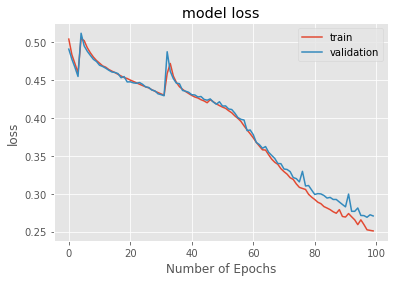

In [59]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('Number of Epochs')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

**Looking at the learning curve aboe we can see that the model loss was good, and it indicated that there was no overfitting in the process having the training loss equal 0.2531 and the validation loss equal 0.2706**

**Model Testing**

**In this block we test the model to see its performance <br>First, we have to encode the words that will be tested to perform the testing and then decoding it back to characters to see the word as an output**

In [64]:
encoder_model = Model(encoder_inputs,encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h,decoder_state_input_c]
decoder_outputs,state_h,state_c = decoder_lstm(decoder_inputs,initial_state = decoder_states_inputs)
decoder_states = [state_h,state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_dec_tokens))
    
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, char2int['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = int2char[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or len(decoded_sentence) > max_dec_len):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_dec_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

for seq_index in range(60,70):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Wrong sentence:', input_texts[seq_index])
    print('Corrected sentence:', decoded_sentence)

-
Wrong sentence: sce2mpaam
Corrected sentence: screenten

-
Wrong sentence: restauant
Corrected sentence: reatrating

-
Wrong sentence: ultimjtely
Corrected sentence: untimatel

-
Wrong sentence: confi6ckd
Corrected sentence: continule

-
Wrong sentence: princessi
Corrected sentence: procesting

-
Wrong sentence: dia5pt8ntd
Corrected sentence: disappoint

-
Wrong sentence: nom9a07ted
Corrected sentence: nonterall

-
Wrong sentence: scqp5eenin
Corrected sentence: screenten

-
Wrong sentence: photograph0
Corrected sentence: photoorale

-
Wrong sentence: dire36tion
Corrected sentence: direction



**So After testing the model; it turns out it works just fine as we can see from the test cases. But, there is a lot of room of improvements; like generalizing the model more to encounter sentences, making the encoder and decoder vectors in a more advanced way, and incresing the number of data and words to make it more general as these are not enough. One improvement that can be applied to make this model more powerful and be able to correct context aware/ sentences is making it bi-directional LSTM or creating a hypird model like BERT-LSTM, and LSTM-LSTM; by making such improvment will enable this model to process better and perform better as well as making it more generalized.**